In [13]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings; warnings.filterwarnings('ignore')
import matplotlib.path as mpath

from functions import *
import sys; sys.path.append("..")
from dataset_manipulation import *
from palette import *
from plot import *
%matplotlib inline

In [18]:
"""plt.rcParams.update({
"text.usetex": True,
"font.family": 'DejaVu Sans',
"font.serif": ["Computer Modern Roman"],
"font.size": 20})"""
plt.rcParams['font.size'] = '18'

In [15]:
casealias = ['CTRL','IDEAL-ON', 'IDEAL-OFF', 'REAL-ON', 'REAL-OFF']
dpi = 300
relative = True

# BVOC

In [5]:
bvoc = load_dataset_dict('BVOC')

## SOA: column burden

In [7]:
soa = load_dataset_dict('SOA')
soa = add_SOA_TOT(soa, casealias)

## Cloud properties

In [8]:
cloud = load_dataset_dict('CLOUDPROP')
for case in casealias:
    cloud[case] = fix_cloud(cloud[case])

## SCATTERPLOTS

In [62]:
#soacloud = xr.merge([soa['CTRL'], cloud['CTRL']], compat='identical')
from scipy import stats
from scipy.optimize import curve_fit
import math
fig_folder = '../../figures/results/'

def time_average(da_dict, case, variable):
    da = da_dict[case][variable].mean('time')
    if variable=='ACTNL' or variable=='ACTREL':
        da = da_dict[case][variable].mean('time')/da_dict[case]['FCTL'].mean('time')
    if variable =='N_AER': da=da.isel(lev=-1)
    return da

def difference(da_dict, case1, case2, variable):
    da1 = time_average(da_dict, case1, variable)
    da2 = time_average(da_dict, case2, variable)
    diff = (da1-da2)
    return diff
def ax_text(ax, text, x, y, **kwargs):
    x0, xmax = ax.set_xlim()
    y0, ymax = ax.set_ylim()
    data_width = xmax - x0
    data_height = ymax - y0
    ax.text(x0 + x* data_width, y0 + y*data_height, text, **kwargs)
    
    
def titleof(var):
    if var == 'N_AER': return r'$N_a$'
    elif var == 'cb_SOA_TOT': return 'SOA c.b.'
    elif var == 'ACTNL': return r'$N_d$'
    elif var == 'ACTREL': return r'$r_e$'
    elif var == 'DOD550': return 'AOD'

    
#difference(soa, cases[0], cases[1], 'N_AER')
#time_average(soa, 'CTRL', 'N_AER')
def naer_cdnc(x, a, b):
    return a*(x**b)


def individual_scatterplots(ds1, ds2, var1, var2):
                        
    fig, axes = plt.subplots(1,5, figsize=[20,5], sharex=True, sharey=True)
                        
    for i, case in enumerate(['CTRL', 'IDEAL-ON', 'IDEAL-OFF', 'REAL-ON', 'REAL-OFF']):

        ax = axes.flat[i]
        ds = xr.merge([time_average(ds1, case, var1).rename(var1), 
                  time_average(ds2, case, var2).rename(var2)], 
                 compat='identical')
        ds.plot.scatter(x = var1, y=var2, ax=ax, alpha=0.2, color='teal')
        ax.set_title(case)
        x = ds[var1].values.flatten()
        y = ds[var2].values.flatten()
        #m, b, *_ = stats.linregress(x, y)
        #ax.axline(xy1=(0, b), slope=m, label=f'$y = {m:.1f}x {b:+.1f}$')
        r, p = stats.pearsonr(x, y)
        print(r,p)
        if var1 == 'N_AER' and var2 == 'ACTNL': 
            popt, pcov = curve_fit(naer_cdnc, x, y)
            ax.plot(x, naer_cdnc(x, *popt), 'yellowgreen', alpha=0.7,label=f'y = {popt[0]:.2f} x^({popt[1]:.2f})')# f'fit: ${:0.2f} x ^{:0.2f}'.format(tuple(popt)))
            ax.legend()
        ax.axvline(x=0., color='gray', alpha=0.5, linestyle='--')
        ax.axhline(y=0., color='gray', alpha=0.5, linestyle='--')
        if not i ==0: ax.set_ylabel('')
        y_text=0.15
        if var1 == 'N_AER' or var1 == 'DOD550': y_text=0.25
        ax_text(ax, 'r = {:0.2f}'.format(r), x=0.6, y=y_text, fontsize=20)
    plt.tight_layout()
    return fig
        #plt.show()
        
def change_scatterplots(ds1, ds2, var1, var2):

        fig, axes = plt.subplots(2,3, figsize=[20,13], sharex=True, sharey=True)
        for i, cases in enumerate([['IDEAL-ON', 'CTRL'], ['IDEAL-ON', 'IDEAL-OFF'], ['IDEAL-OFF', 'CTRL'], 
                                   ['REAL-ON', 'CTRL'], ['REAL-ON', 'REAL-OFF'], ['REAL-OFF', 'CTRL']]):
            ax = axes.flat[i]
            ds = xr.merge([difference(ds1, cases[0], cases[1], var1).rename(var1), 
                      difference(ds2, cases[0], cases[1], var2).rename(var2)], 
                     compat='identical')
            #if var2 == 'ACTNL': 
                #ds = ds.where(difference(soa, cases[0], cases[1], 'N_AER')>0.).fillna(0.)
            
            print(ds[var1].max().values, ds[var2].max().values)
            ds.plot.scatter(x = var1, y=var2, ax=ax, alpha=0.2, color='orangered')
            x = ds[var1].values.flatten()
            y = ds[var2].values.flatten()
            m, b, *_ = stats.linregress(x, y)
            r, p = stats.pearsonr(x, y)
            print(r,p)
            ax.axline(xy1=(0, b), slope=m, label=f'$y = {m:.1f}x {b:+.1f}$', color='maroon')
            ax.axvline(x=0., color='gray', alpha=0.5, linestyle='--')
            ax.axhline(y=0., color='gray', alpha=0.5, linestyle='--')
            ax.set_title(cases[0]+' – '+cases[1])
            if i ==0 or i ==1 or i==2: ax.set_xlabel('')
            if i ==1 or i ==2 or i==4 or i ==5: ax.set_ylabel('')
            ax_text(ax, 'r = {:0.2f}'.format(r), x=0.7, y=0.1, fontsize=20)
        plt.tight_layout()
        #plt.ioff()
        return fig
        #plt.show()
    
def scatterplots(ds1, ds2, var1, var2, title, figsize=[20,25], dpi=300):
    backend = mpl.get_backend()
    mpl.use('agg')

    #plot_args = dict(nrows=1, ncols=2, figsize=[figsize[0]/4.*1.3, figsize[1]/6.], dpi=dpi, subplot_kw={'projection':ccrs.Orthographic(0, 90)})

    figs = []
    axes = []

    fig = individual_scatterplots(ds1, ds2, var1, var2)
    figs.append(fig)
    fig = change_scatterplots(ds1, ds2, var1, var2)
    figs.append(fig)


    a_list = []
    for fig in figs:
        c = fig.canvas
        c.draw()
        a_list.append(np.array(c.buffer_rgba()))

    a = np.vstack(a_list)

    mpl.use(backend)
    fig,ax = plt.subplots(figsize=figsize)
    fig.subplots_adjust(0, 0, 1, 1)
    ax.set_axis_off()
    ax.matshow(a)
    plt.suptitle(title, size=33, y=0.9)
    figtitle = fig_folder+titleof(var1)+' - '+titleof(var2)
    #if relative: figtitle=figtitle+'_seasons_relative'
    plt.savefig(figtitle+'.pdf', pad_inches=0.3, bbox_inches='tight')
    plt.show()

0.9084470764782026 0.0
0.908562547796705 0.0
0.9077096991501901 0.0
0.9087243272142254 0.0
0.9088058172921727 0.0
57.0458984375 5.7042999267578125
-0.05535945194032704 0.001130824122320374
31.0738525390625 6.318504333496094
0.33814471428752346 3.3983957318275115e-93
94.413818359375 8.465141296386719
0.31979603008186086 5.1272636583717444e-83
105.45526123046875 7.8774566650390625
0.012423075098407413 0.46533599445832685
123.25631713867188 8.561012268066406
0.26700702624501893 1.703534219993636e-57
49.2568359375 8.466545104980469
0.28407248355600445 3.7229793481518153e-65
-0.7935821148062403 0.0
-0.7937544190683252 0.0
-0.7938975427397096 0.0
-0.7941881988239762 0.0
-0.7940022913058274 0.0
57.0458984375 0.3847675323486328
-0.05597225294148686 0.000995224058154995
31.0738525390625 0.4113750457763672
-0.19955318681155937 2.246955347387846e-32
94.413818359375 0.4364004135131836
-0.19905713463443664 3.214391227533144e-32
105.45526123046875 0.3843221664428711
-0.17958400129107807 1.9385581414

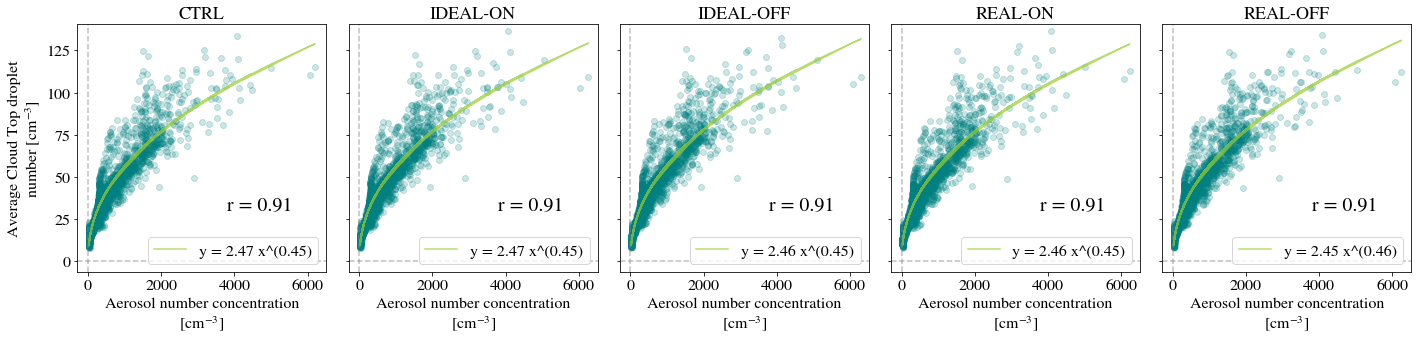

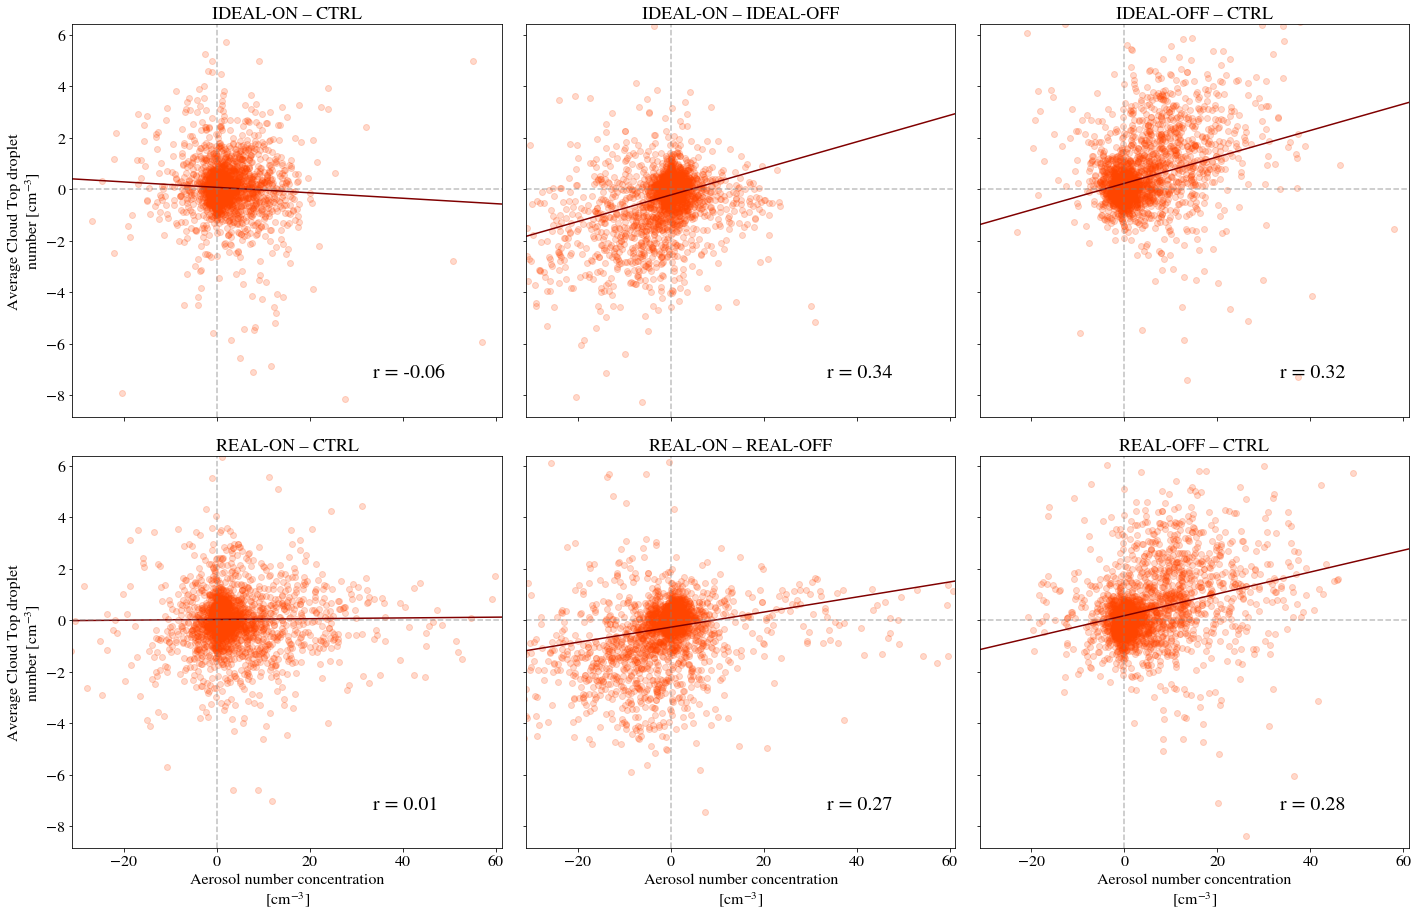

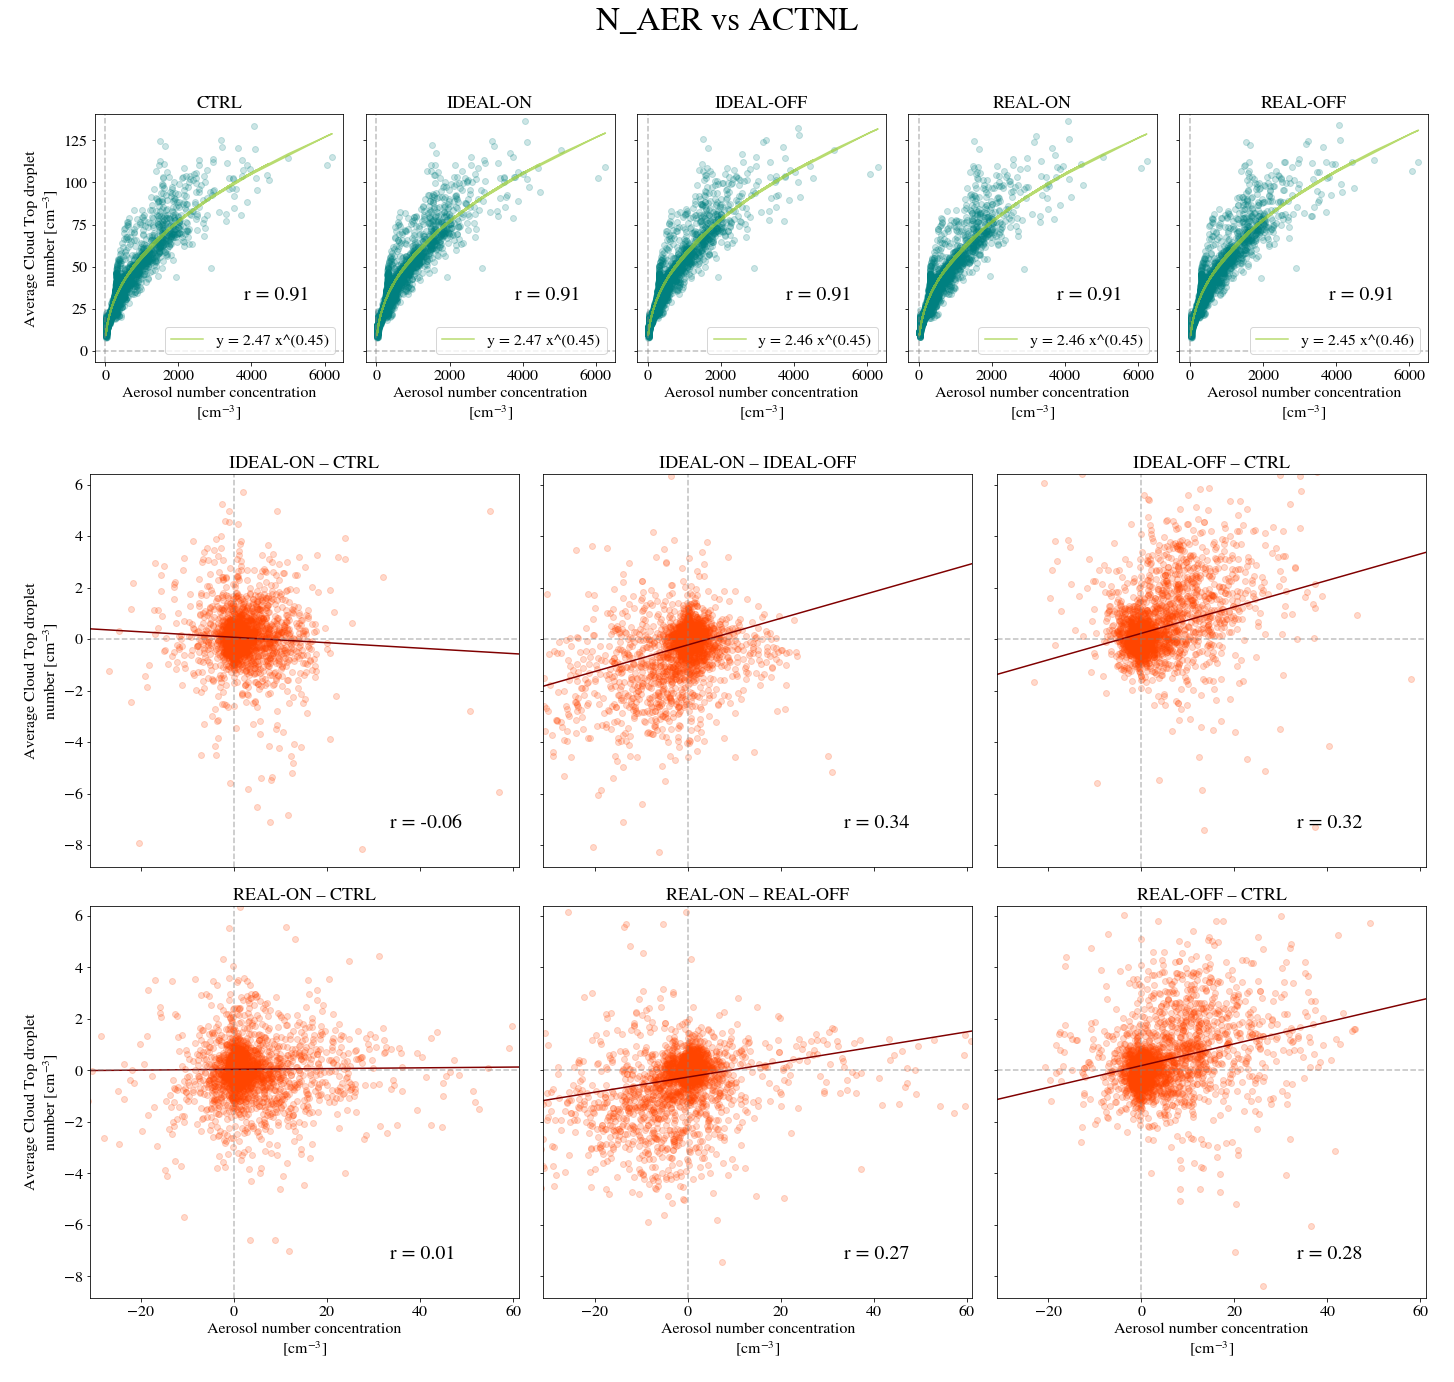

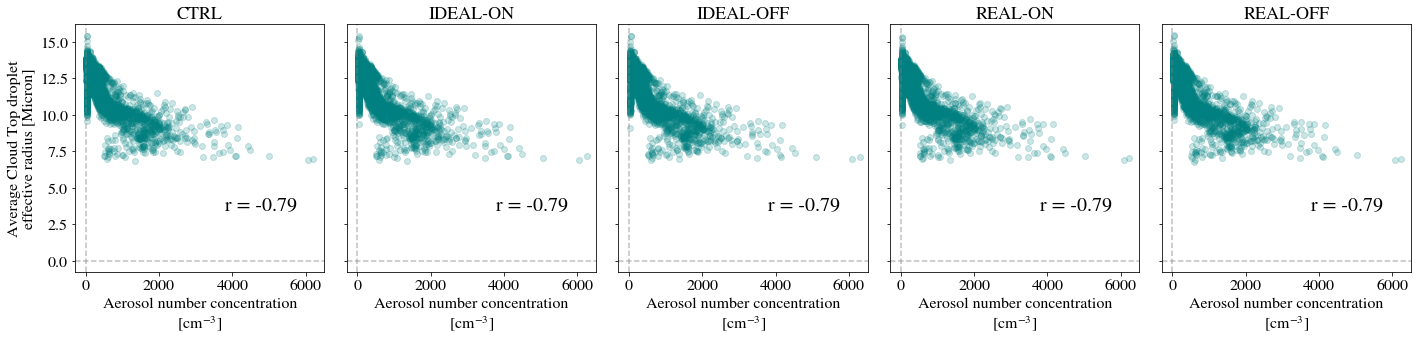

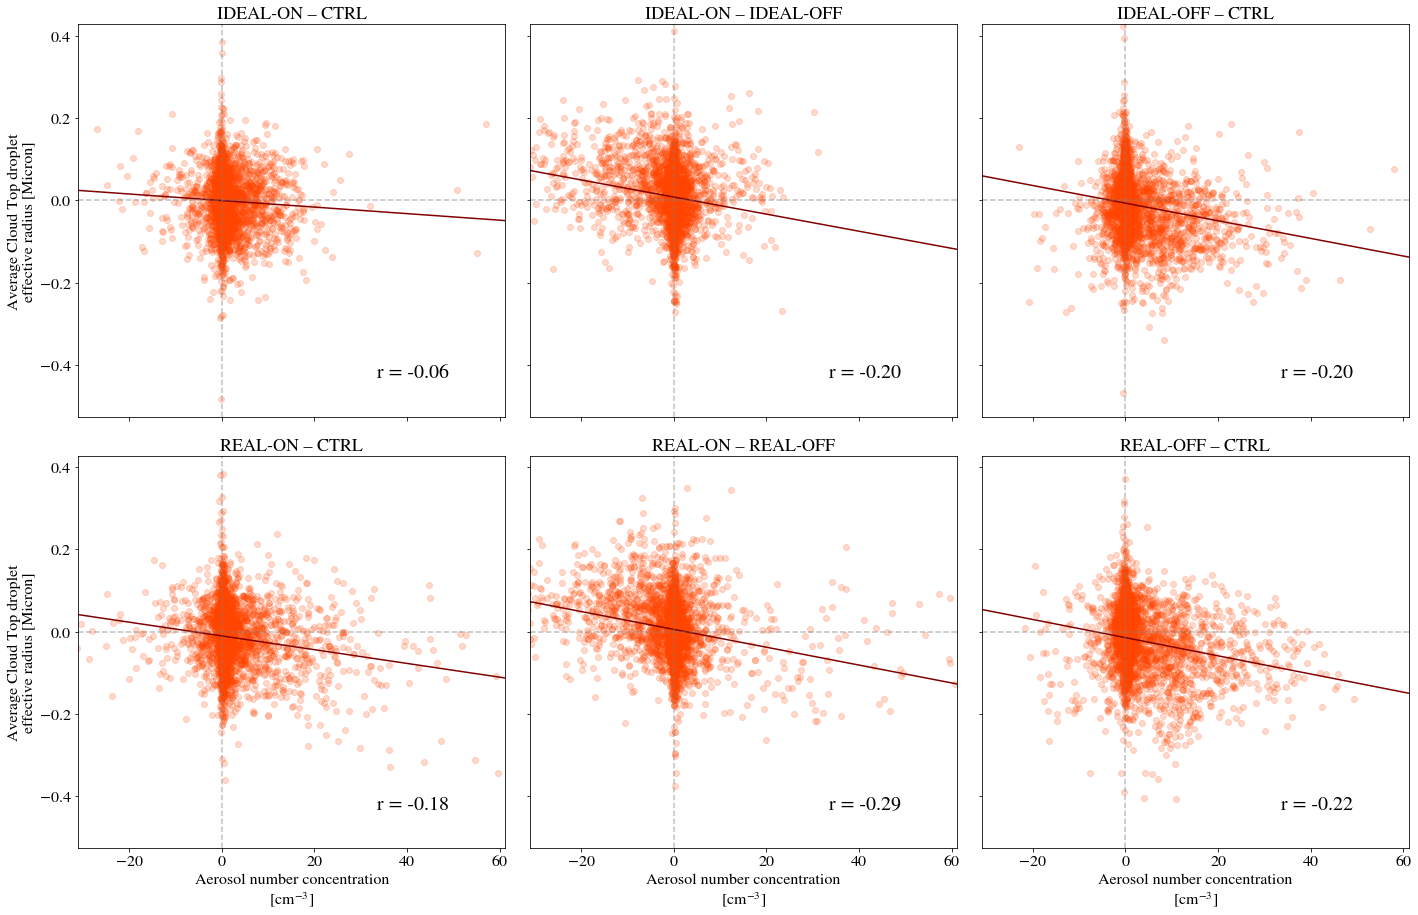

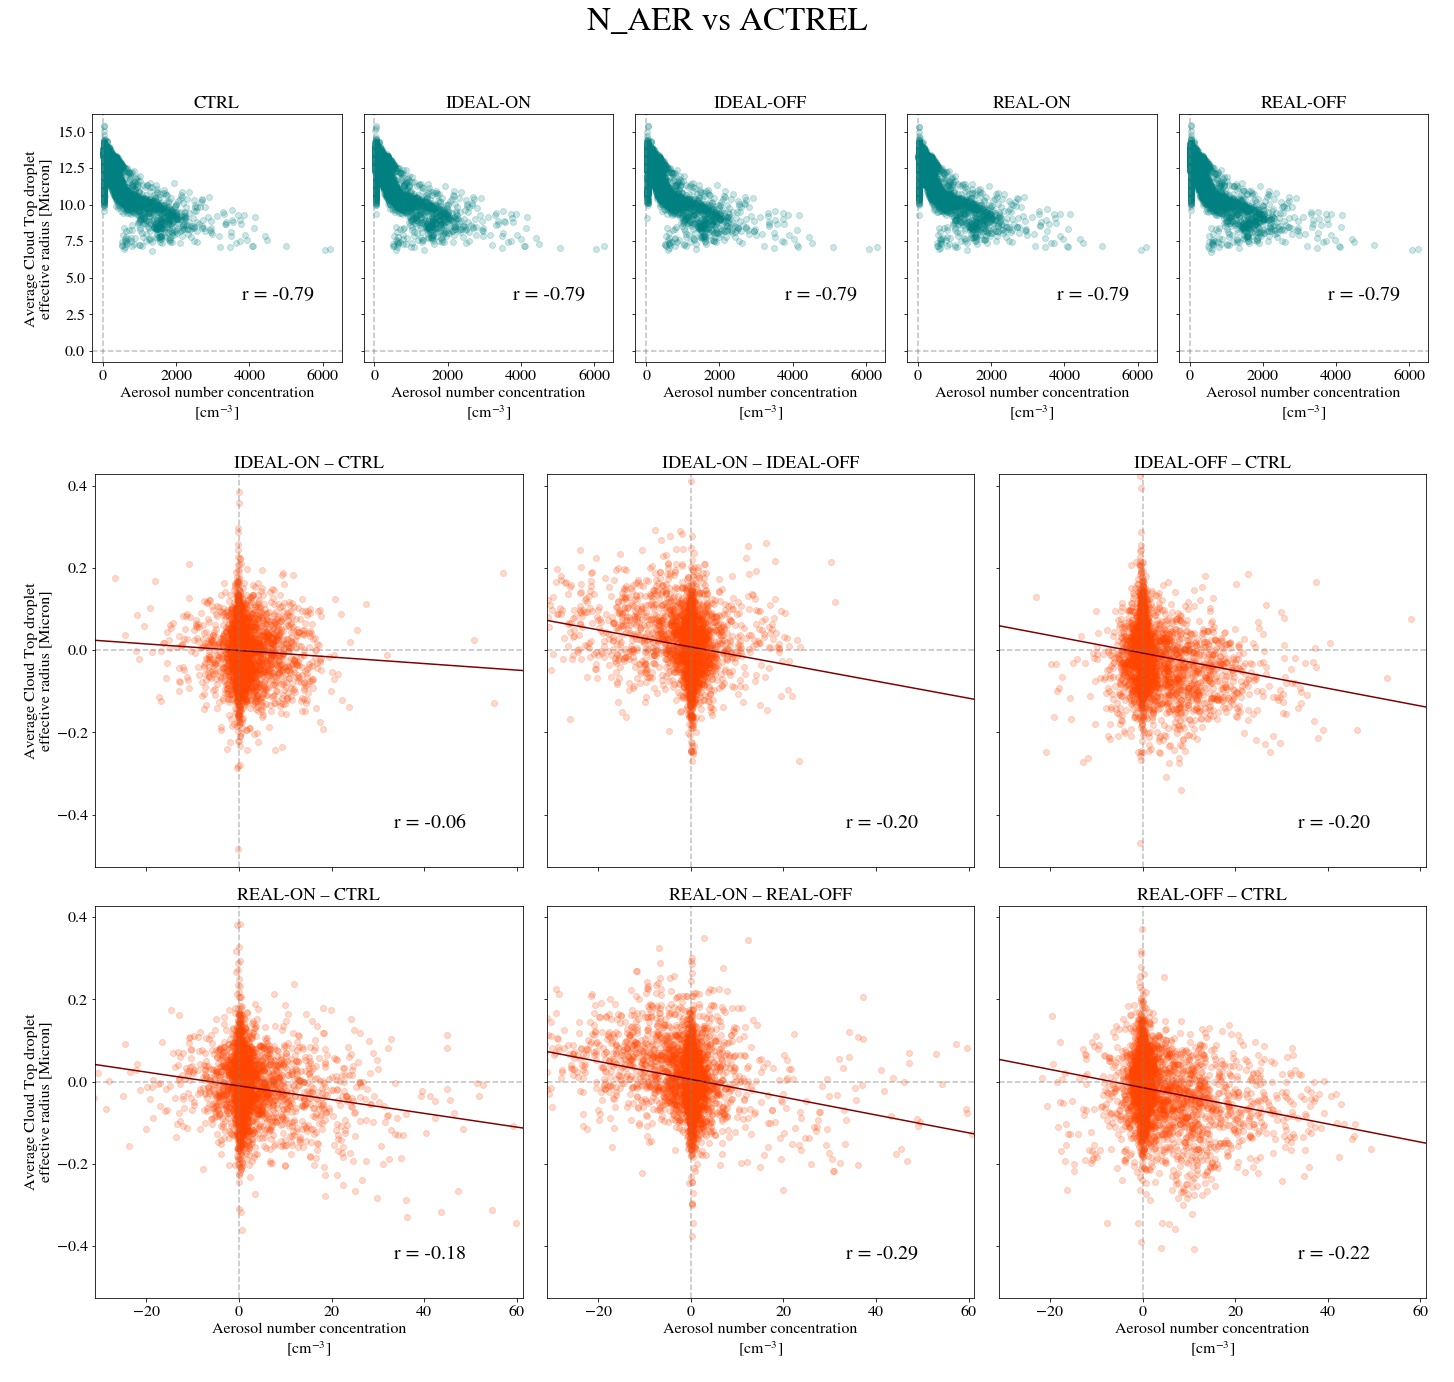

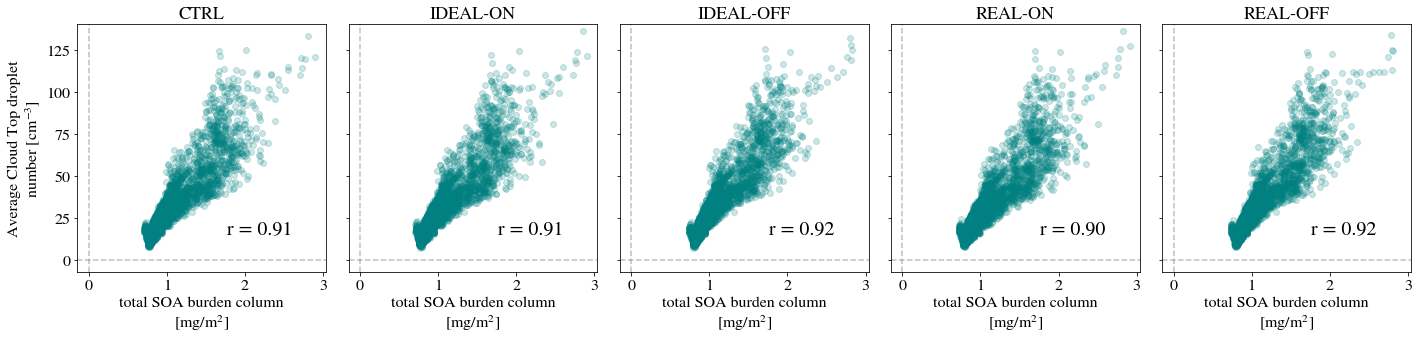

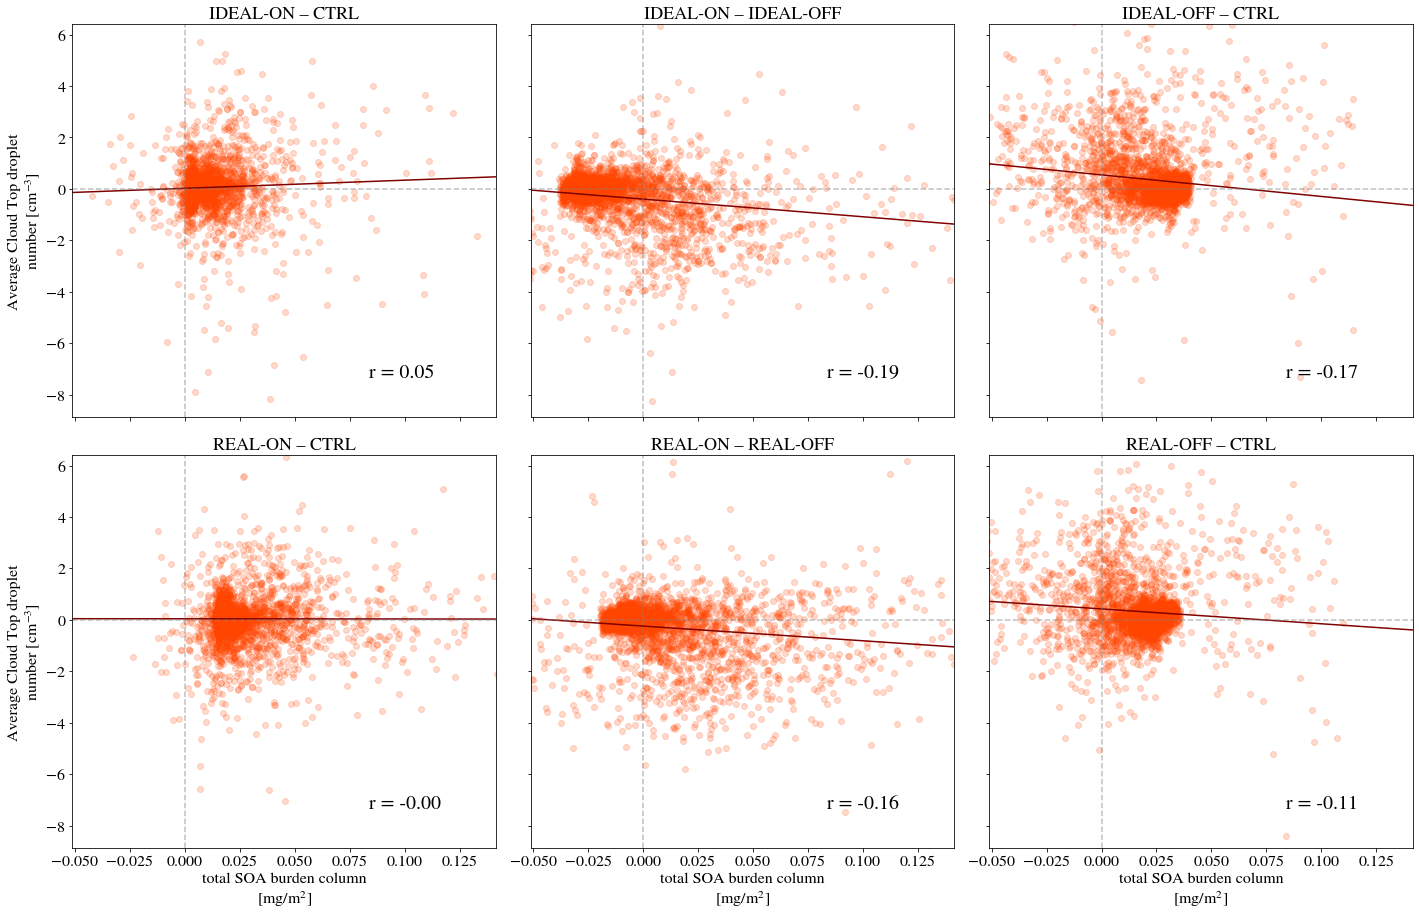

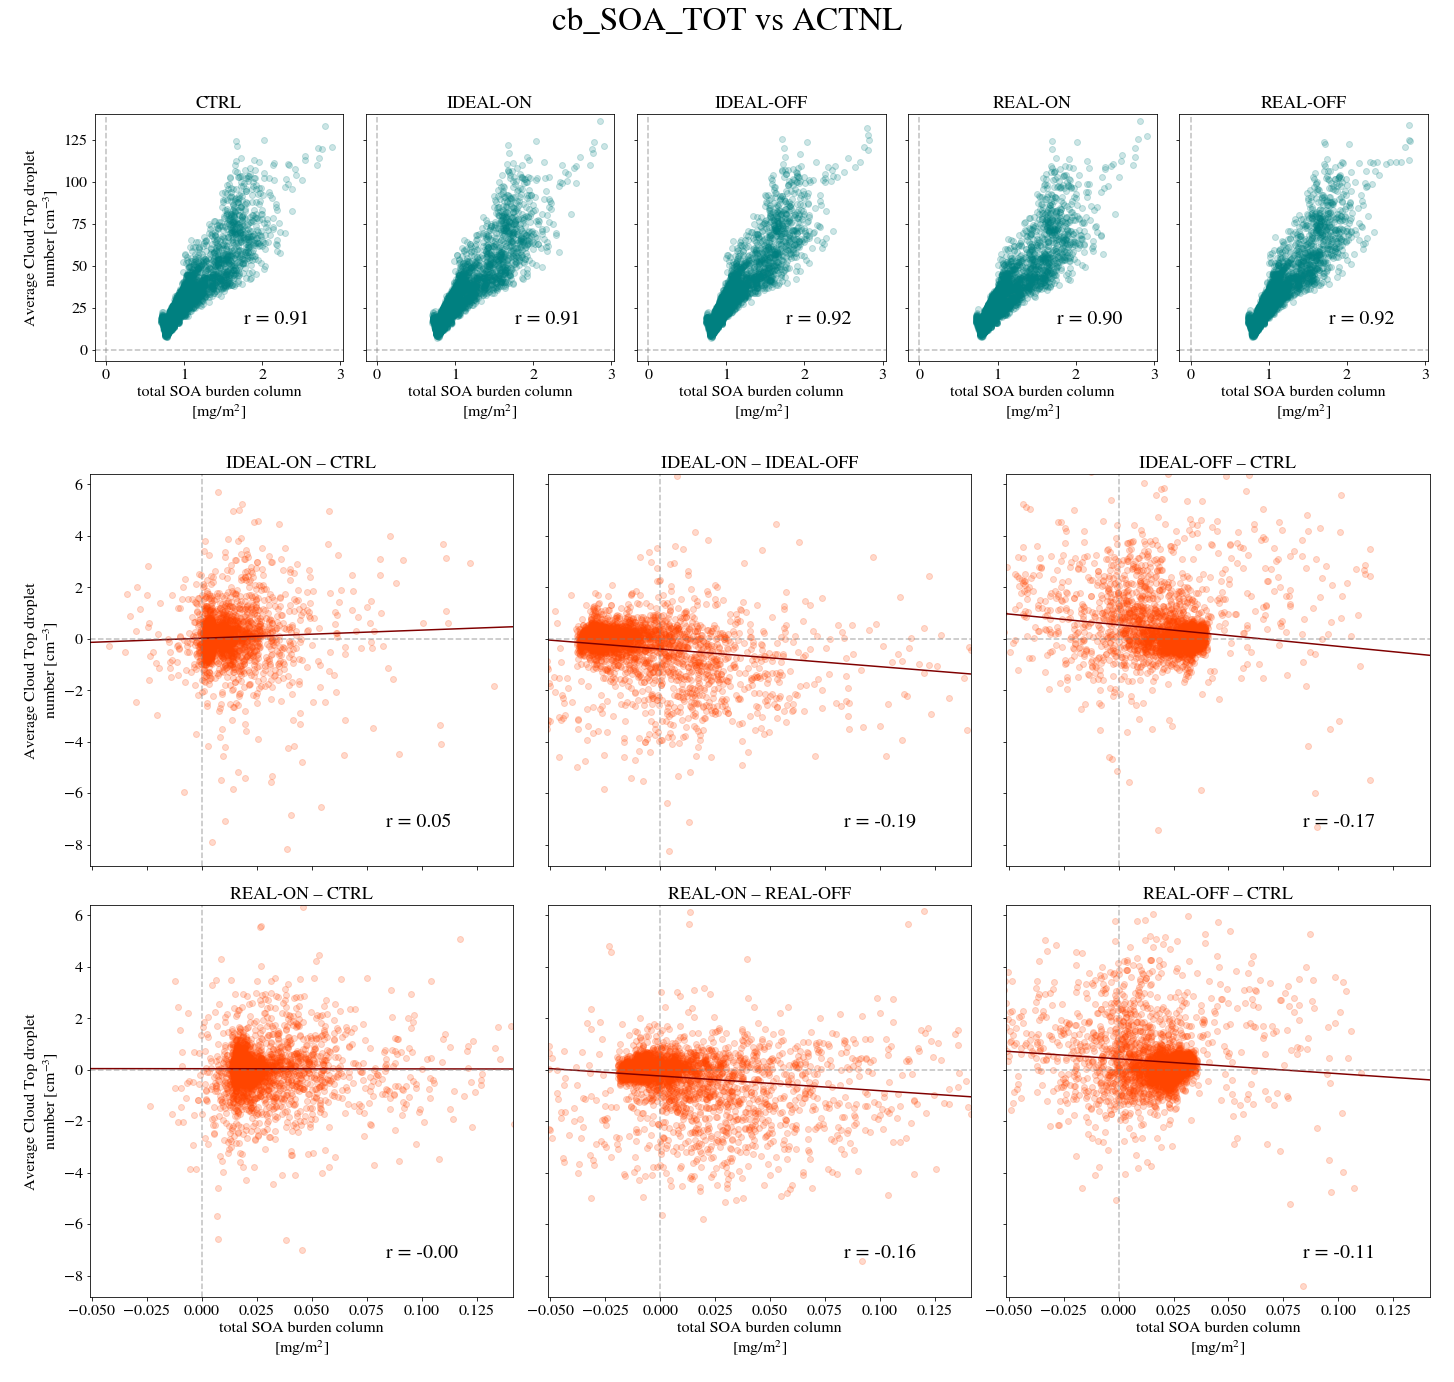

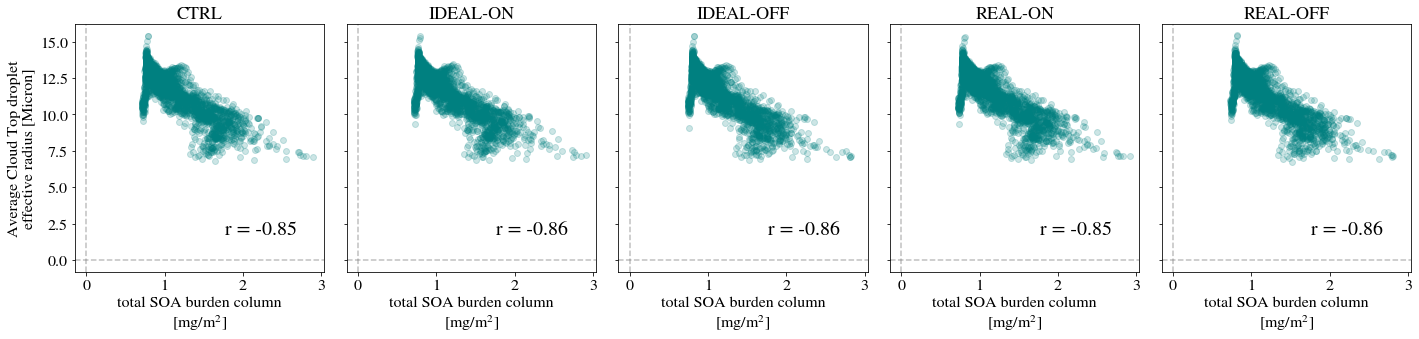

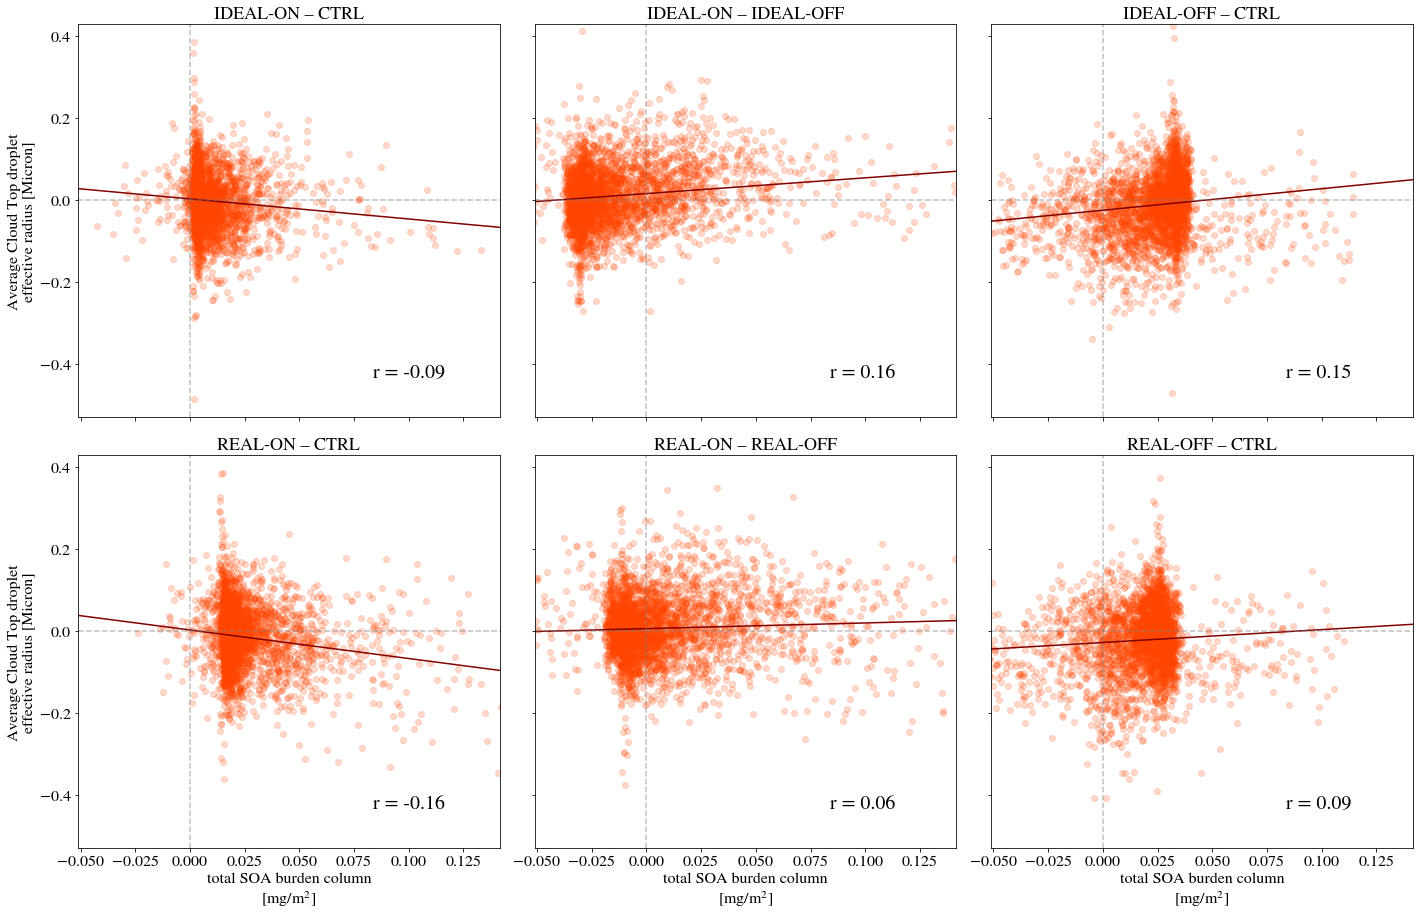

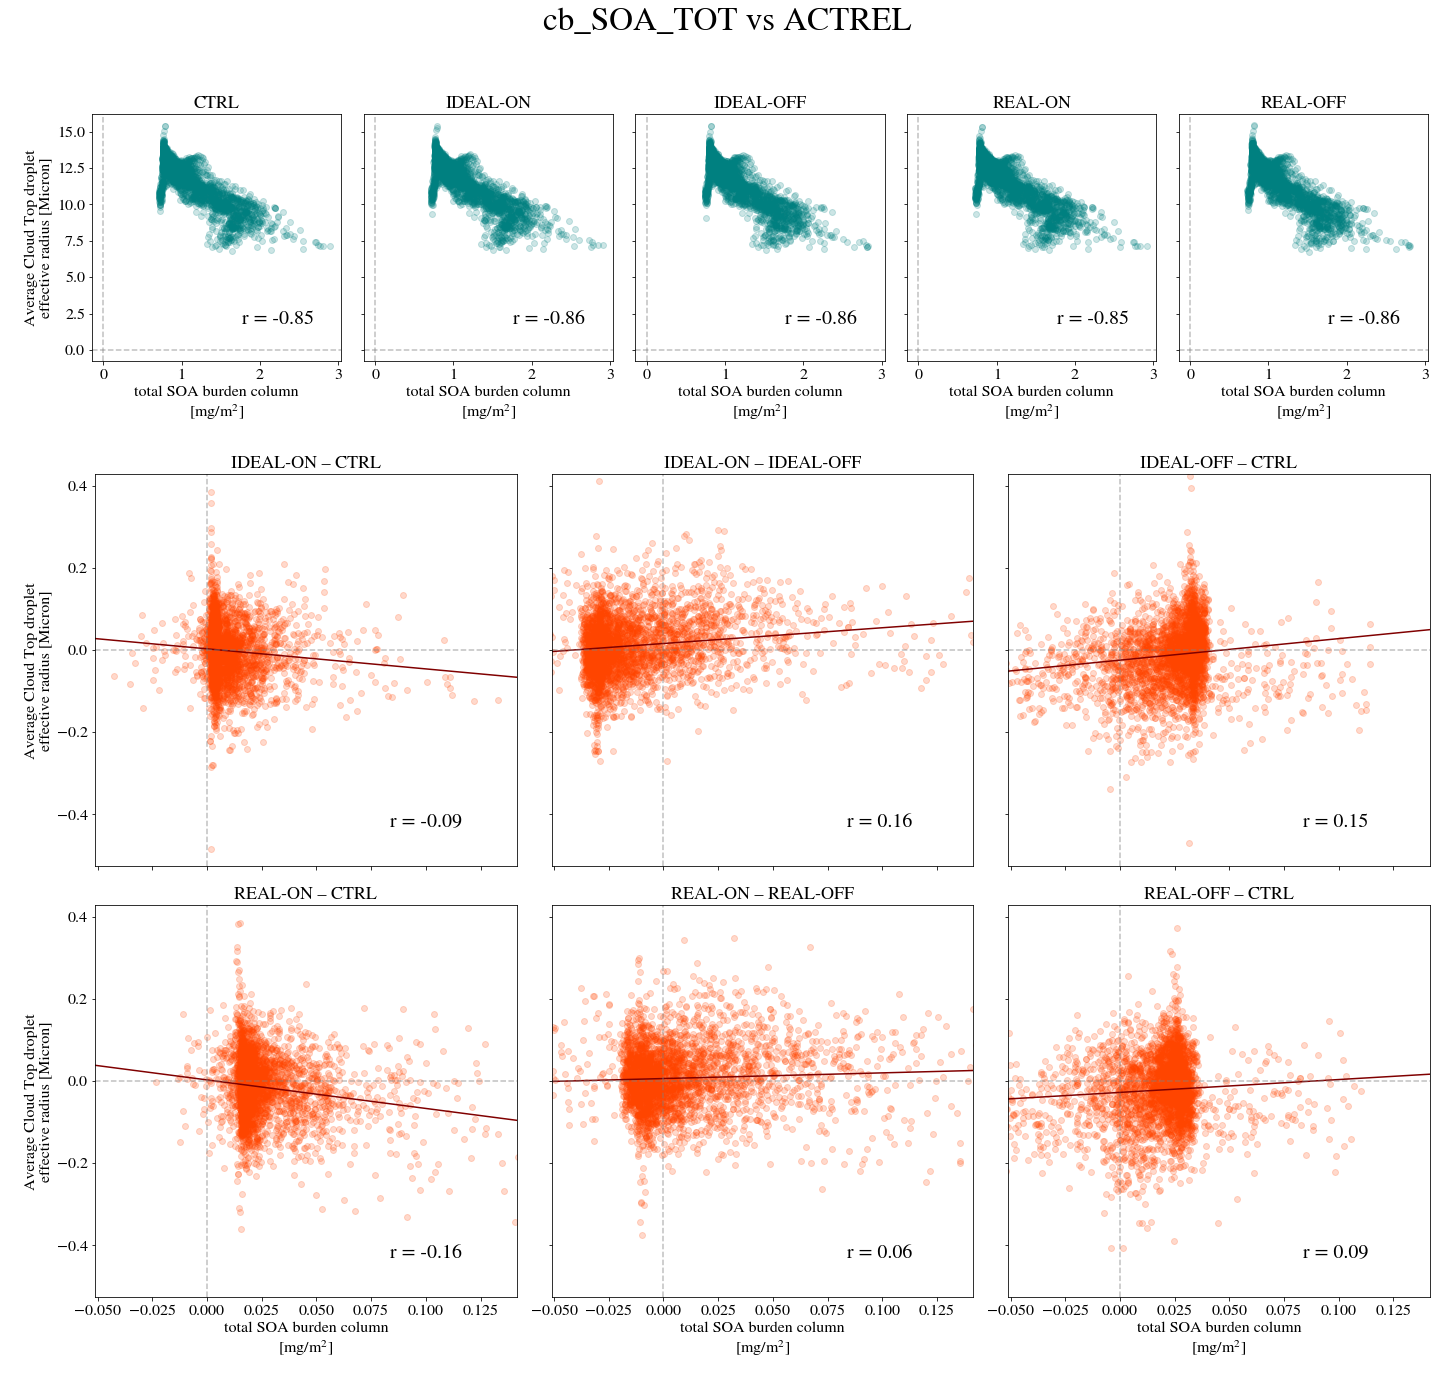

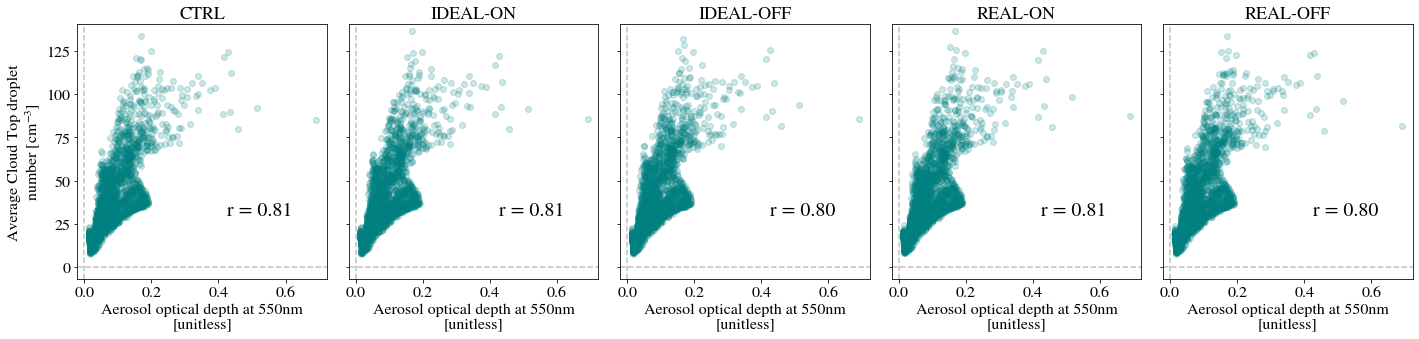

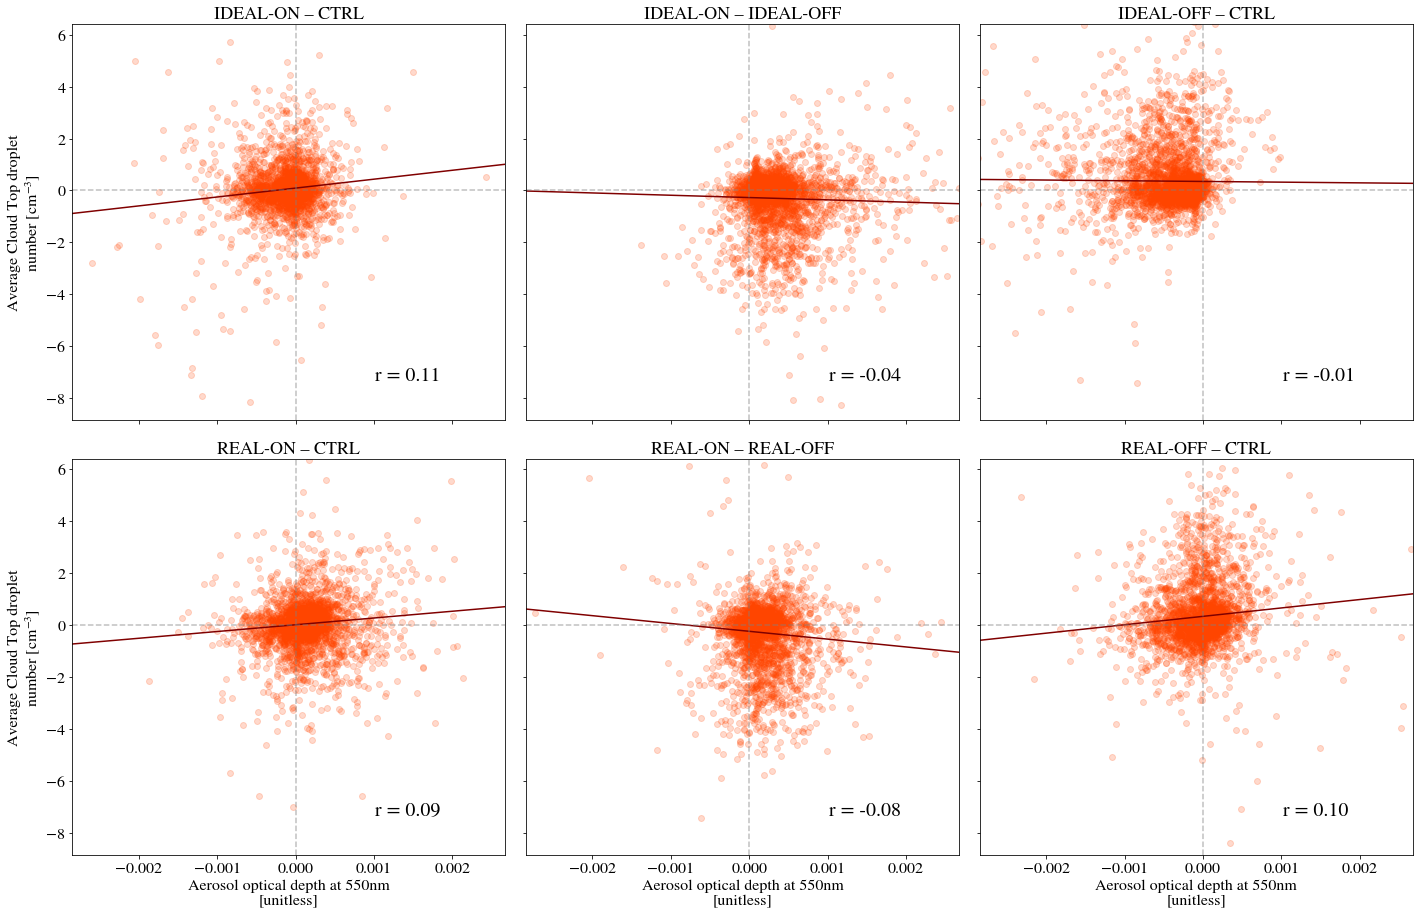

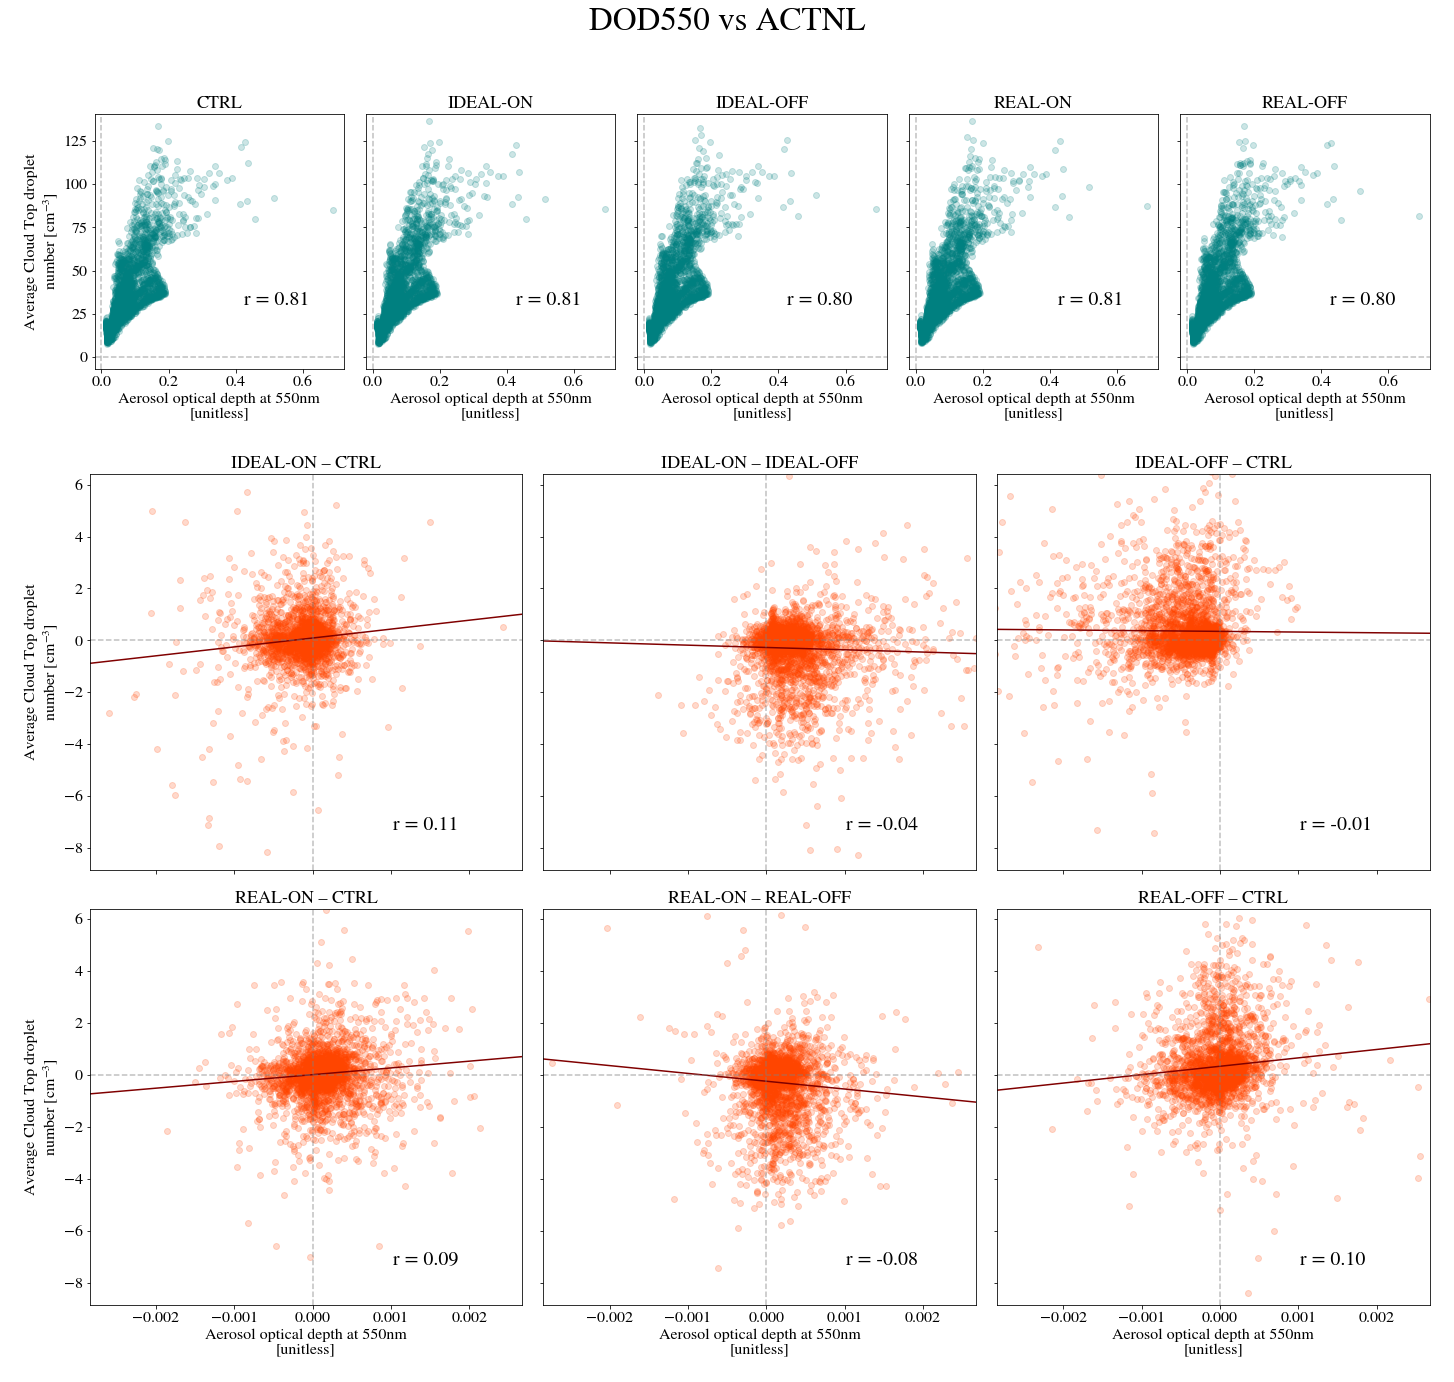

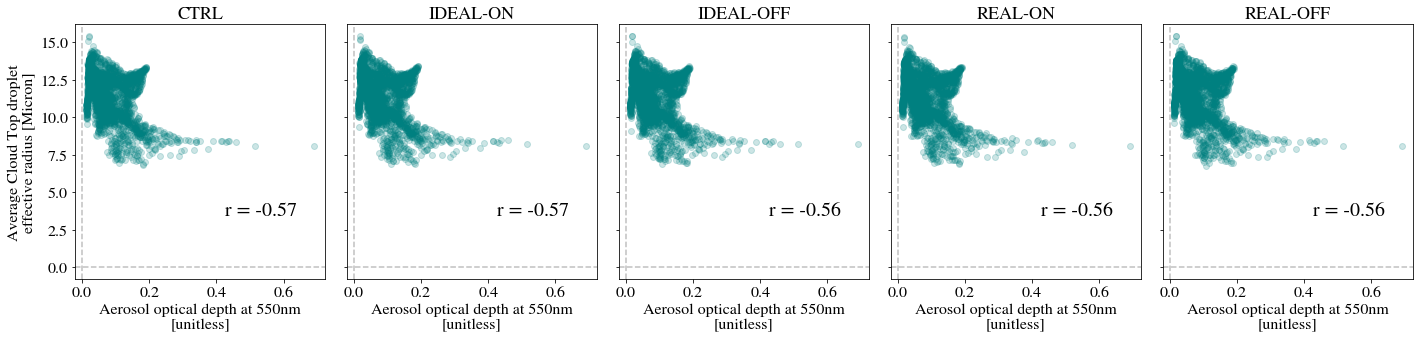

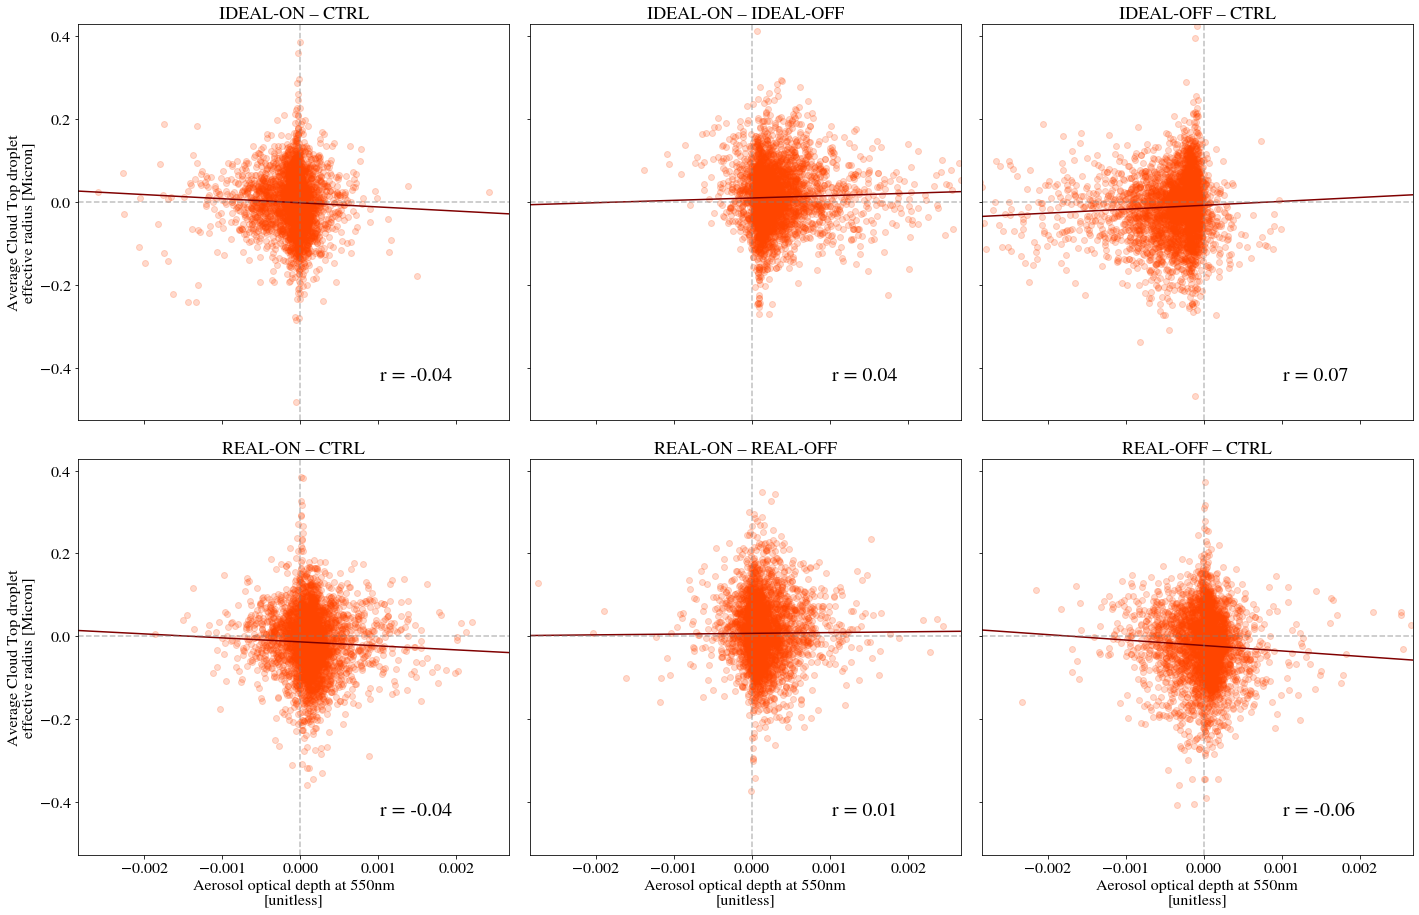

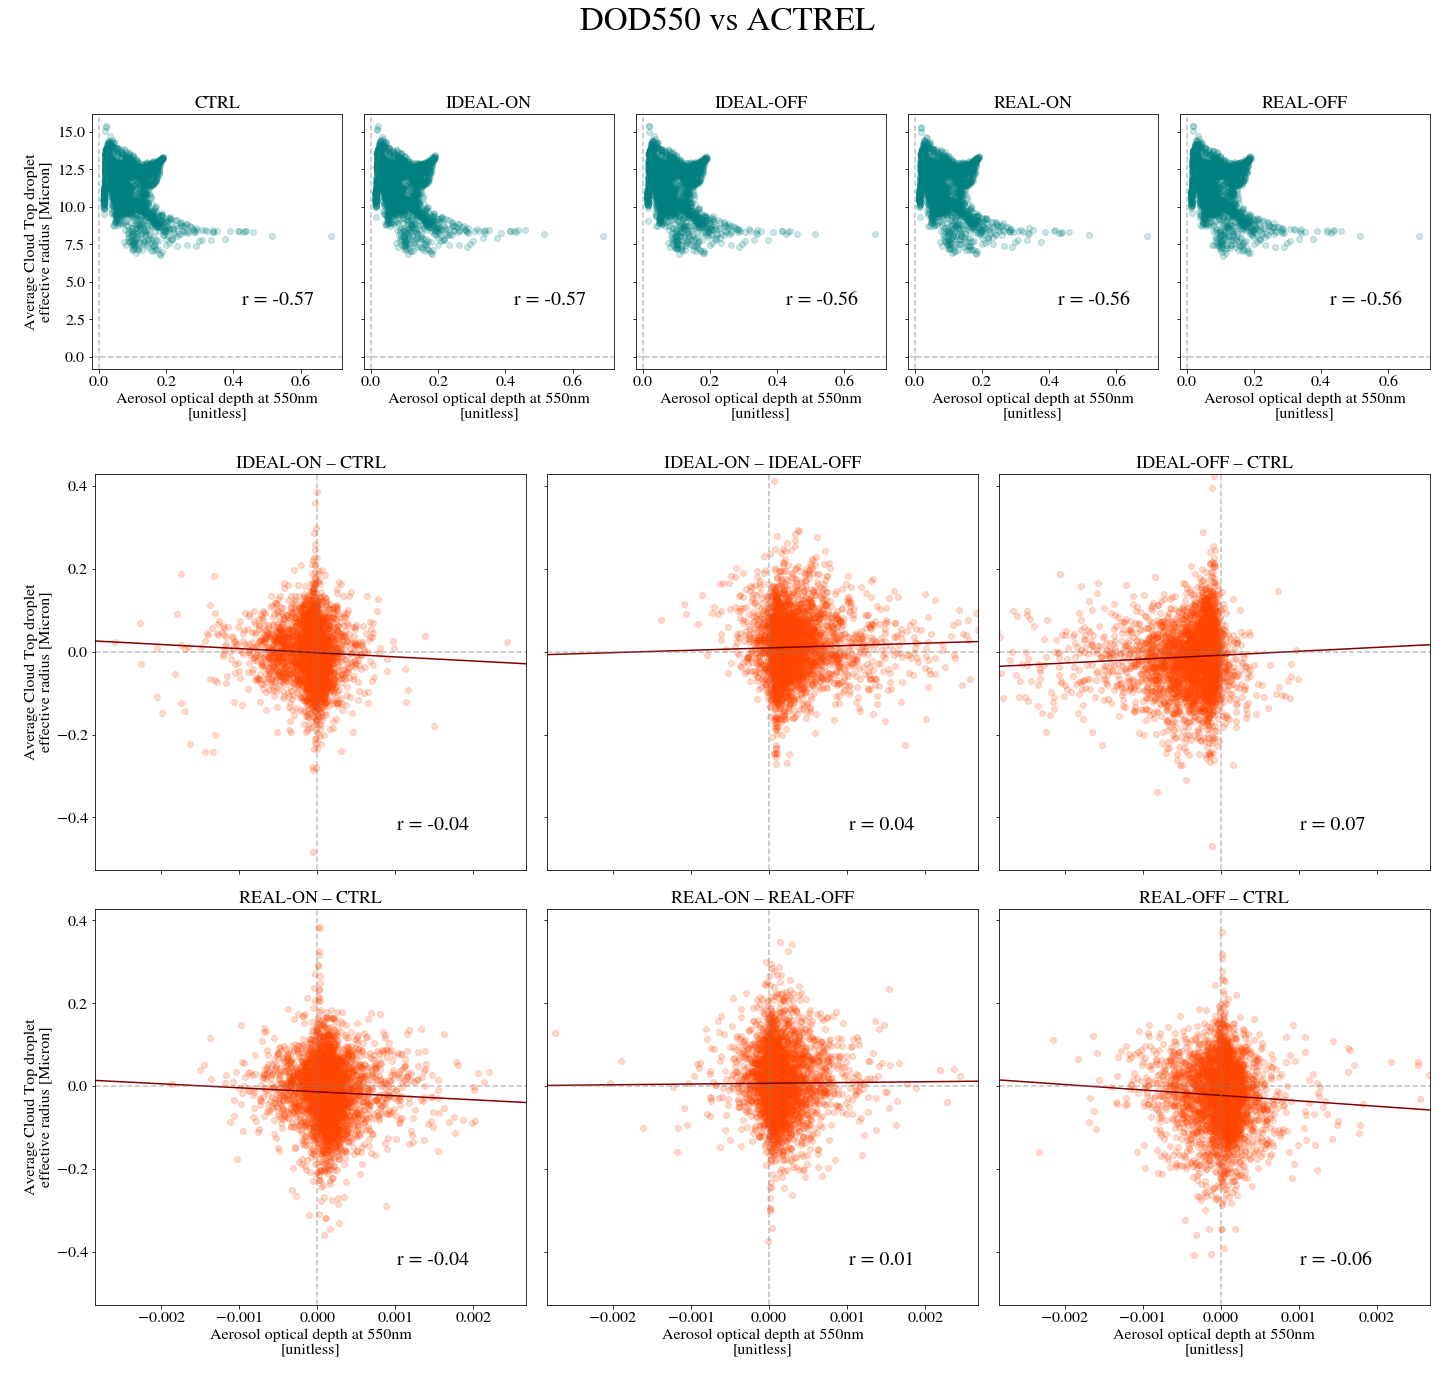

In [63]:
for var1 in ['N_AER', 'cb_SOA_TOT', 'DOD550']:
    for var2 in ['ACTNL', 'ACTREL']:
        scatterplots(soa, cloud, var1, var2, title = var1+' vs '+var2)

0.696284757142747 0.0
0.6947520985718015 0.0
0.6989308547104893 0.0
0.6818017365236456 0.0
0.6983635269281446 0.0
588.7300415039062 57.0458984375
0.09059121465295457 9.570306815678722e-08
587.1951904296875 31.0738525390625
-0.11062764761411235 6.973646479313673e-11
58.024932861328125 94.413818359375
-0.07029353196116145 3.5338037446271696e-05
534.1307373046875 105.45526123046875
0.053304887634048934 0.0017198907611769127
519.0936279296875 123.25631713867188
0.005001716831560376 0.7688074448066164
58.024932861328125 49.2568359375
-0.12165087796751536 7.195973074564529e-13


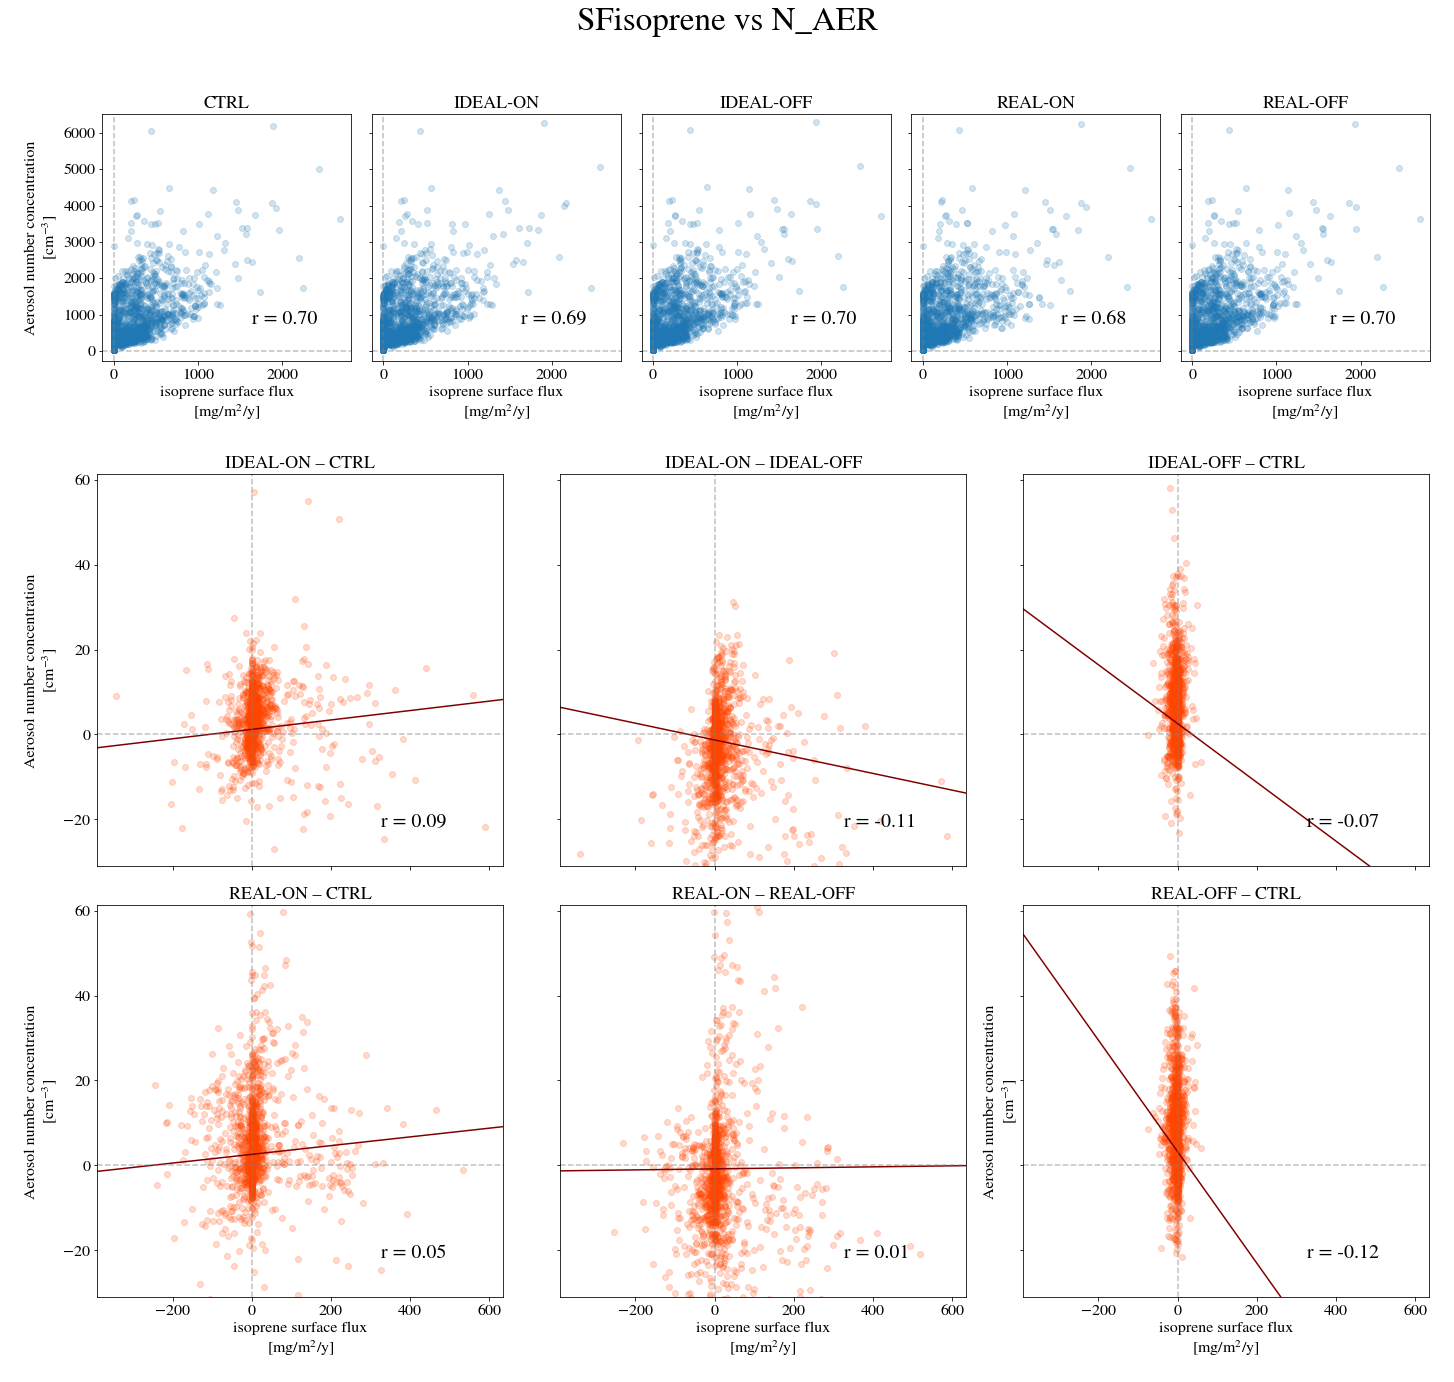

0.7614449385709738 0.0
0.7617617607812823 0.0
0.76610697613989 0.0
0.7567863286099624 0.0
0.7658736195871652 0.0
588.7300415039062 0.13280272483825684
0.6299171750912672 0.0
587.1951904296875 0.23427414894104004
0.4416052346090057 6.06086989010414e-165
58.024932861328125 0.11447596549987793
0.3584433948667438 2.7229575062119347e-105
534.1307373046875 0.15169799327850342
0.5265868215198312 6.887623388707763e-246
519.0936279296875 0.26206421852111816
0.4038220218137725 1.0187268554812437e-135
58.024932861328125 0.11010241508483887
0.3496889064074431 5.780674767171244e-100


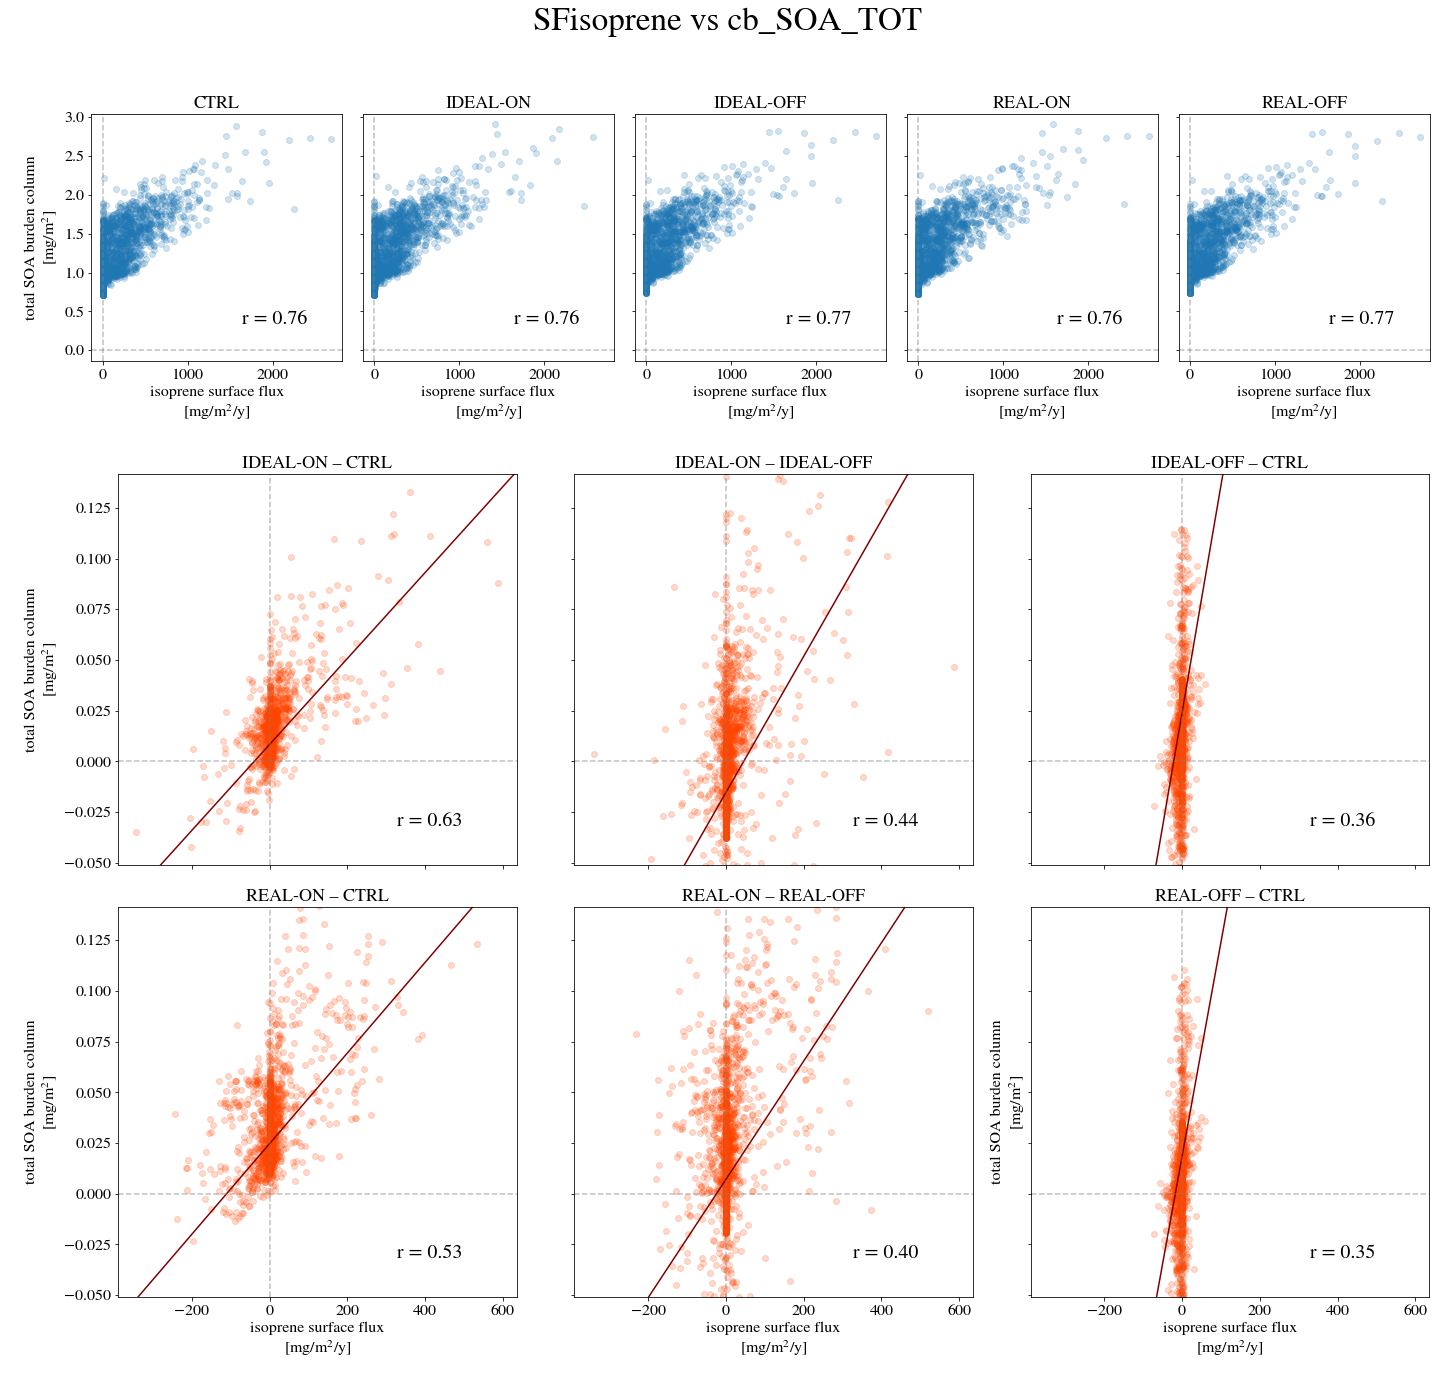

0.2983258150646549 5.577286725922774e-72
0.293674977257528 1.0388960358992015e-69
0.2973372811623778 1.7079855013721415e-71
0.290165533516865 5.031471458716054e-68
0.2994968868765002 1.4727357106683714e-72
588.7300415039062 0.0024243593215942383
0.11220066400185431 3.727241455360161e-11
587.1951904296875 0.004202678799629211
0.18221097091821037 3.5020140210021424e-27
58.024932861328125 0.0009828656911849976
0.1433141101796257 2.543985572265577e-17
534.1307373046875 0.0027532577514648438
0.0602477692578923 0.0003944506168319398
519.0936279296875 0.0024461746215820312
0.16580273492672581 1.0033803464796936e-22
58.024932861328125 0.0033202767372131348
0.15979367012432144 3.346413816054325e-21


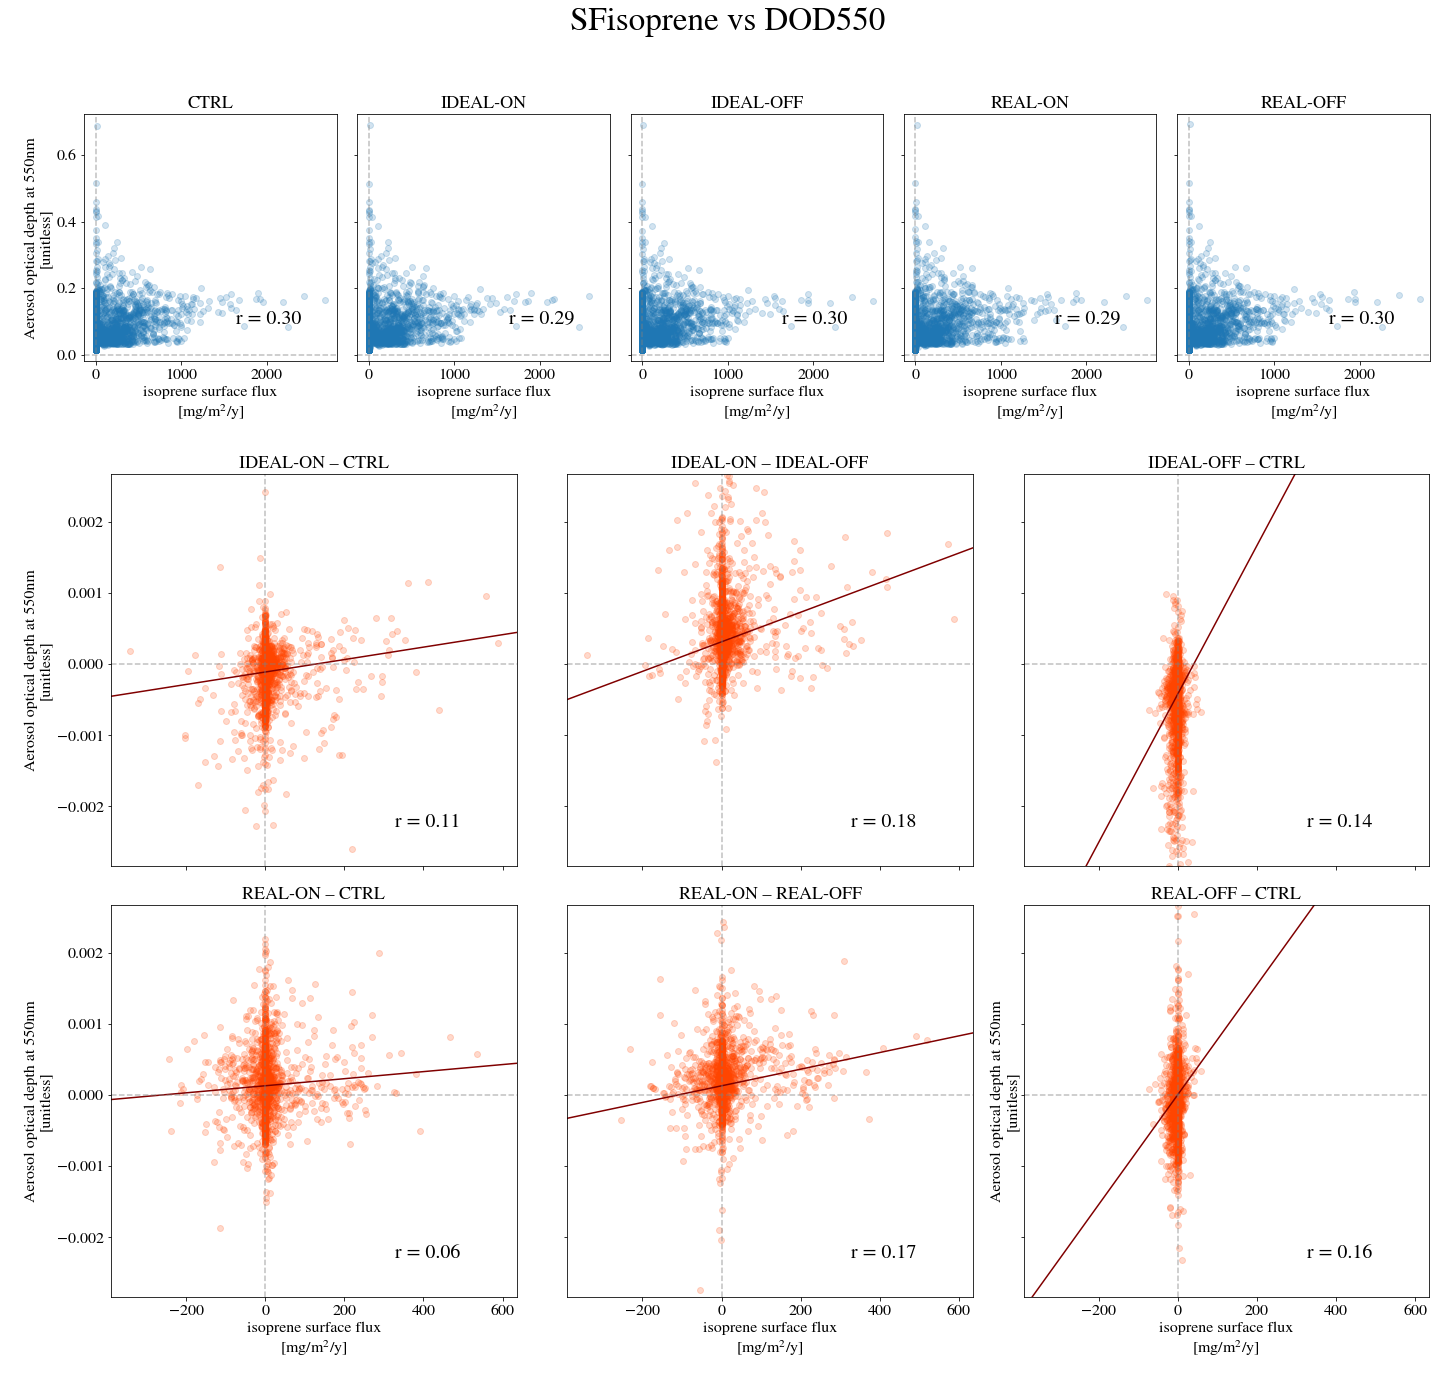

0.5692358833143147 4.5963840654914926e-296
0.5628268492588041 4.728534315275978e-288
0.5725781701385502 2.591302761750143e-300
0.5615547255942044 1.7549611817271367e-286
0.5737460600732586 8.265332114427884e-302
131.2750244140625 57.0458984375
0.24238012316057483 2.1690574270051065e-47
136.77825927734375 31.0738525390625
0.47137420863921287 9.862832329204107e-191
25.61328125 94.413818359375
-0.07227668925839323 2.1091604830881565e-05
213.115478515625 105.45526123046875
0.5892359114841945 3.06e-322
222.08009338378906 123.25631713867188
0.5987801623183036 0.0
25.61328125 49.2568359375
-0.14227771490751034 4.317190797386848e-17


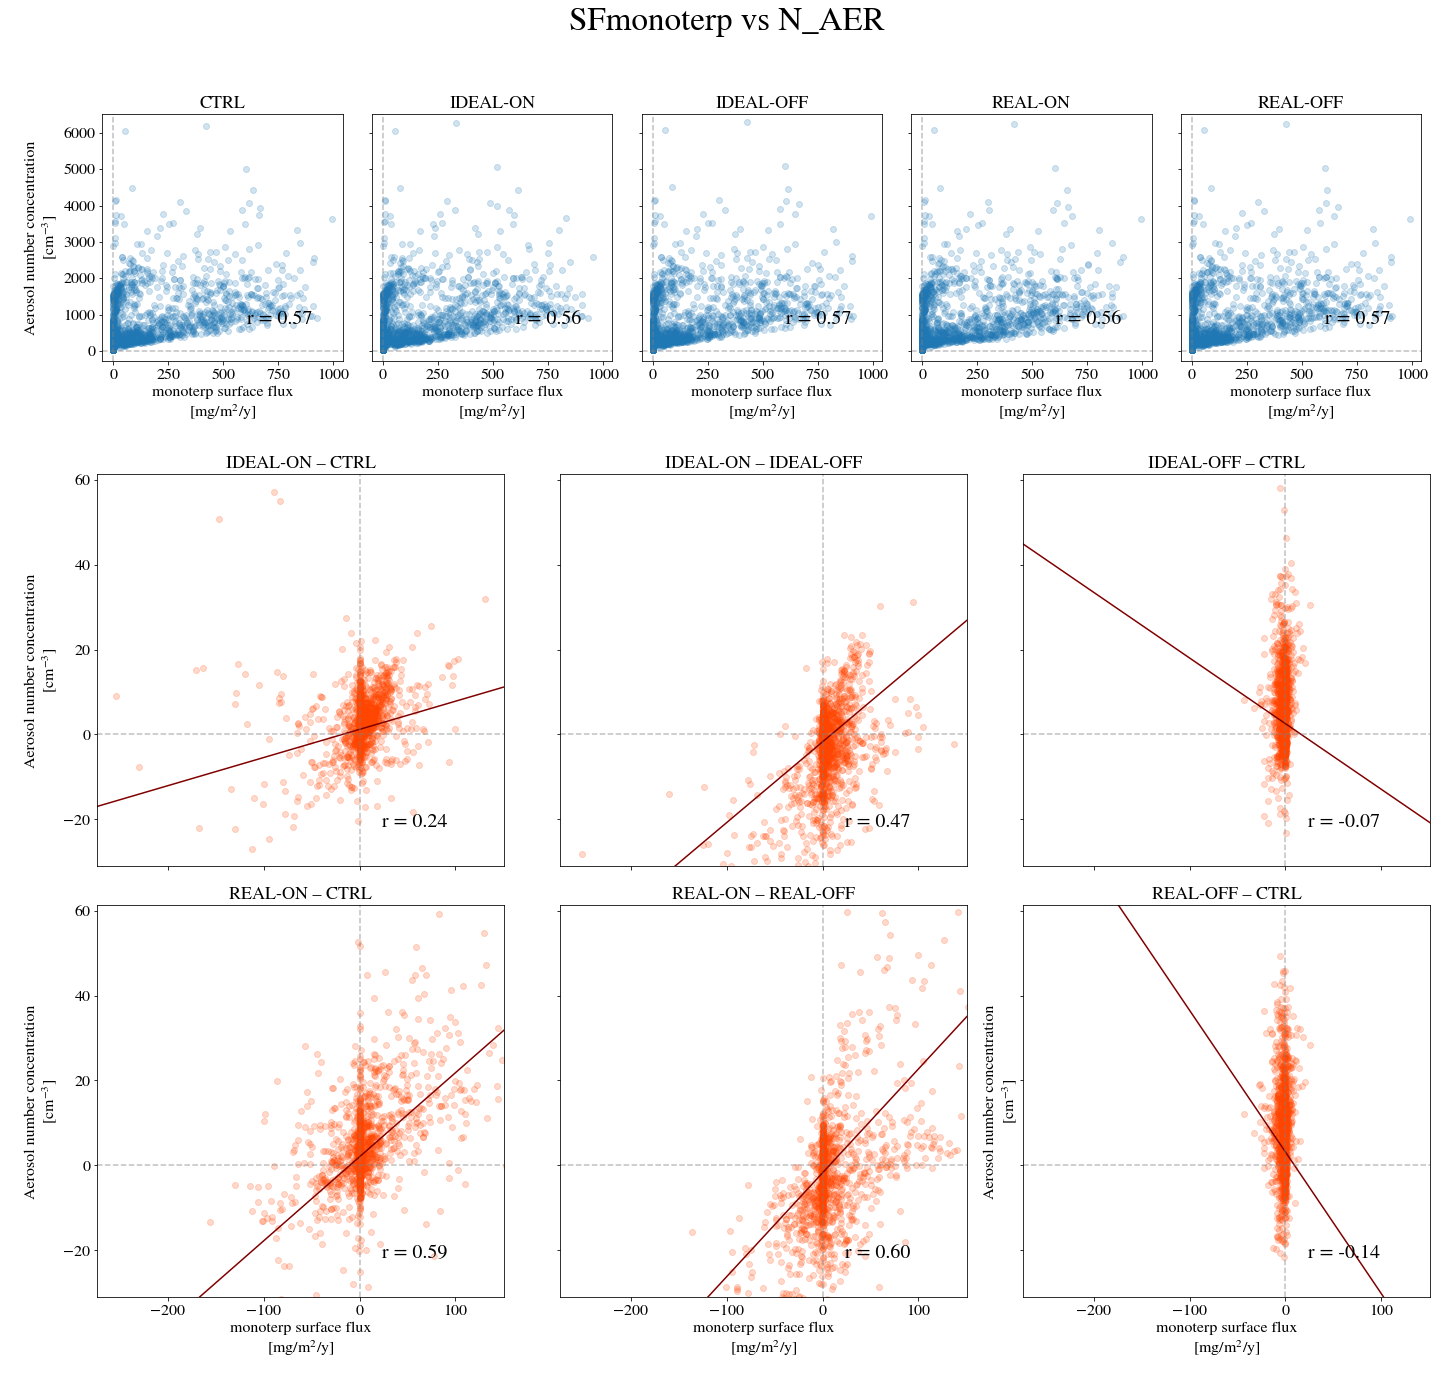

0.729877710549636 0.0
0.7296039648844299 0.0
0.7266501694012109 0.0
0.7334359807711572 0.0
0.7266258912975616 0.0
131.2750244140625 0.13280272483825684
0.2764127759568743 1.194410960316815e-61
136.77825927734375 0.23427414894104004
0.214768430746009 2.3966371004622506e-37
25.61328125 0.11447596549987793
0.41276916033576394 2.6442135958637996e-142
213.115478515625 0.15169799327850342
0.5047388925029053 7.64573103712353e-223
222.08009338378906 0.26206421852111816
0.38795723370937885 1.5807791246144473e-124
25.61328125 0.11010241508483887
0.4083290001671616 5.197325964148362e-139


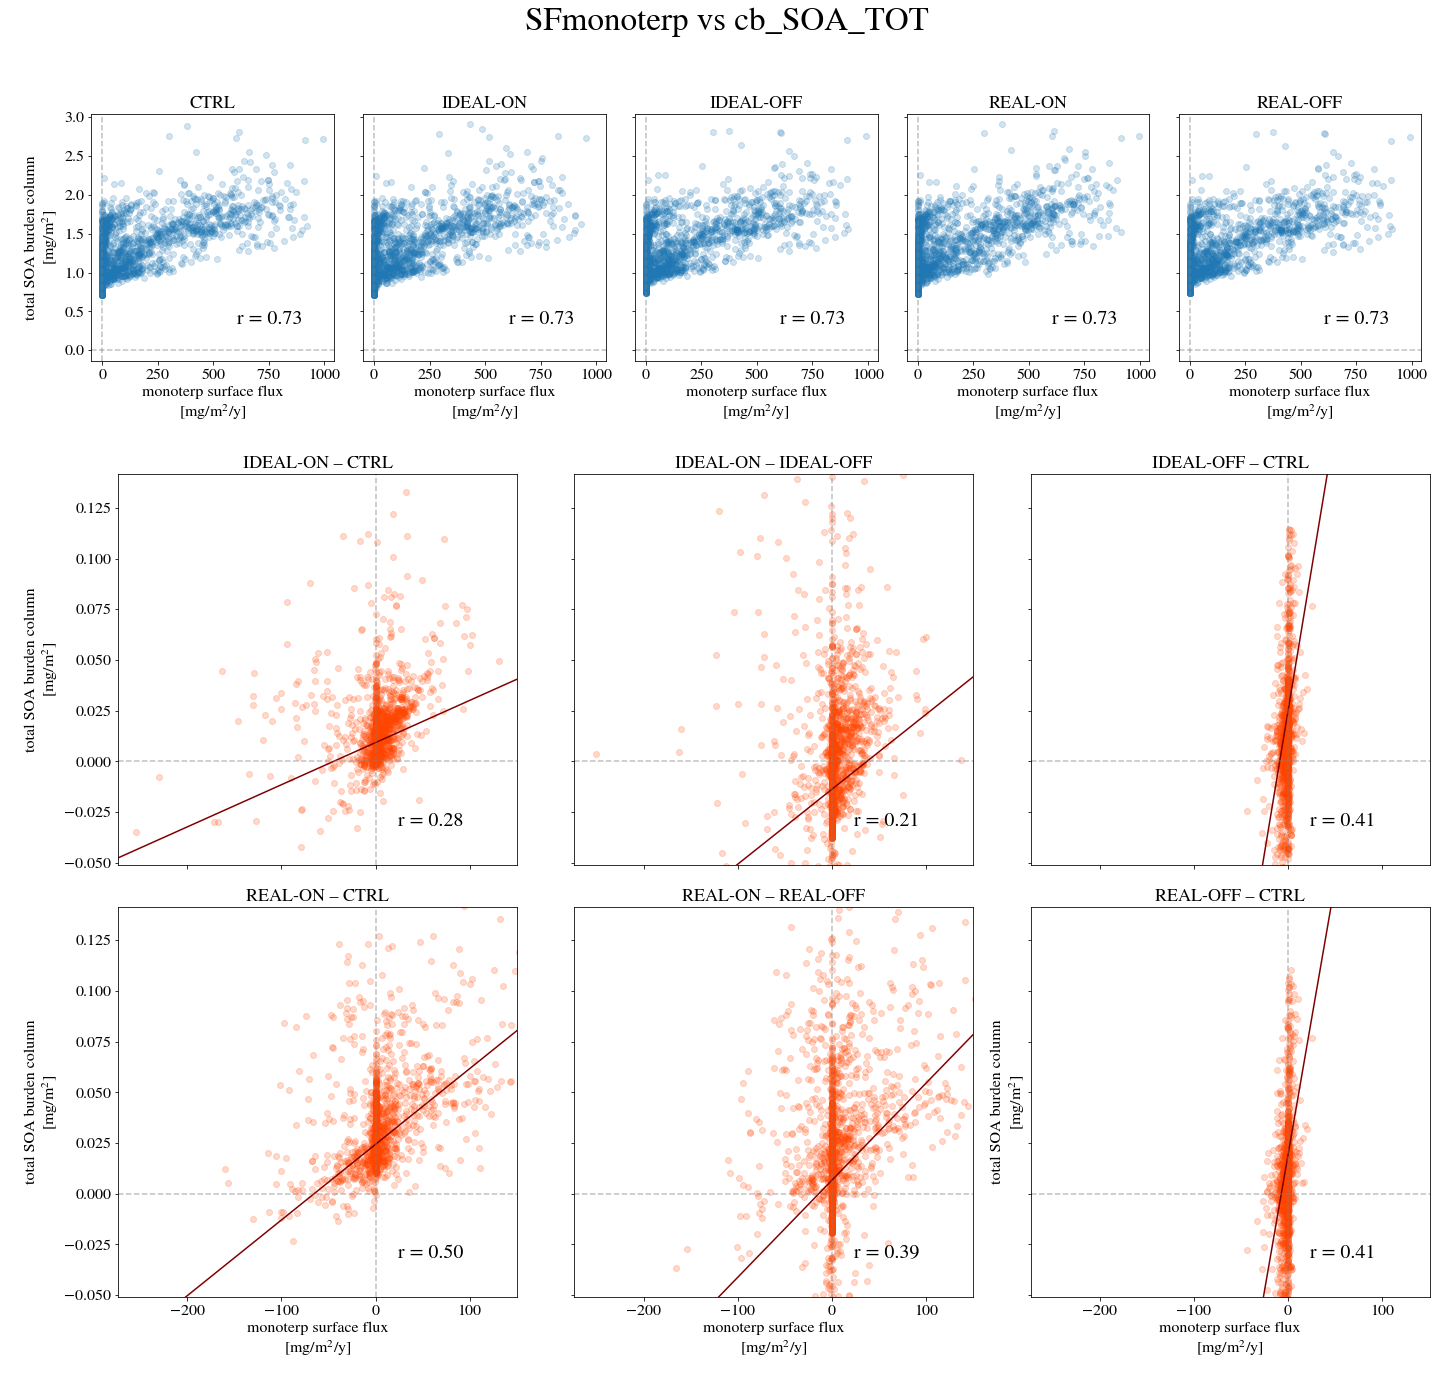

0.23674288359128426 3.129801216734914e-45
0.23439452763928187 2.389937527329709e-44
0.23744810154581458 1.692325434993263e-45
0.2270295510288774 1.2142791781187763e-41
0.23817115210590625 8.9904940724443e-46
131.2750244140625 0.0024243593215942383
0.11620147450412119 7.283729652975274e-12
136.77825927734375 0.004202678799629211
0.10270341082863185 1.4347984150000516e-09
25.61328125 0.0009828656911849976
0.08449680092404917 6.542367968450112e-07
213.115478515625 0.0027532577514648438
-0.020069090688658774 0.238195655256986
222.08009338378906 0.0024461746215820312
0.16443310997550492 2.2580834724379668e-22
25.61328125 0.0033202767372131348
0.07525181126554305 9.486225776781367e-06


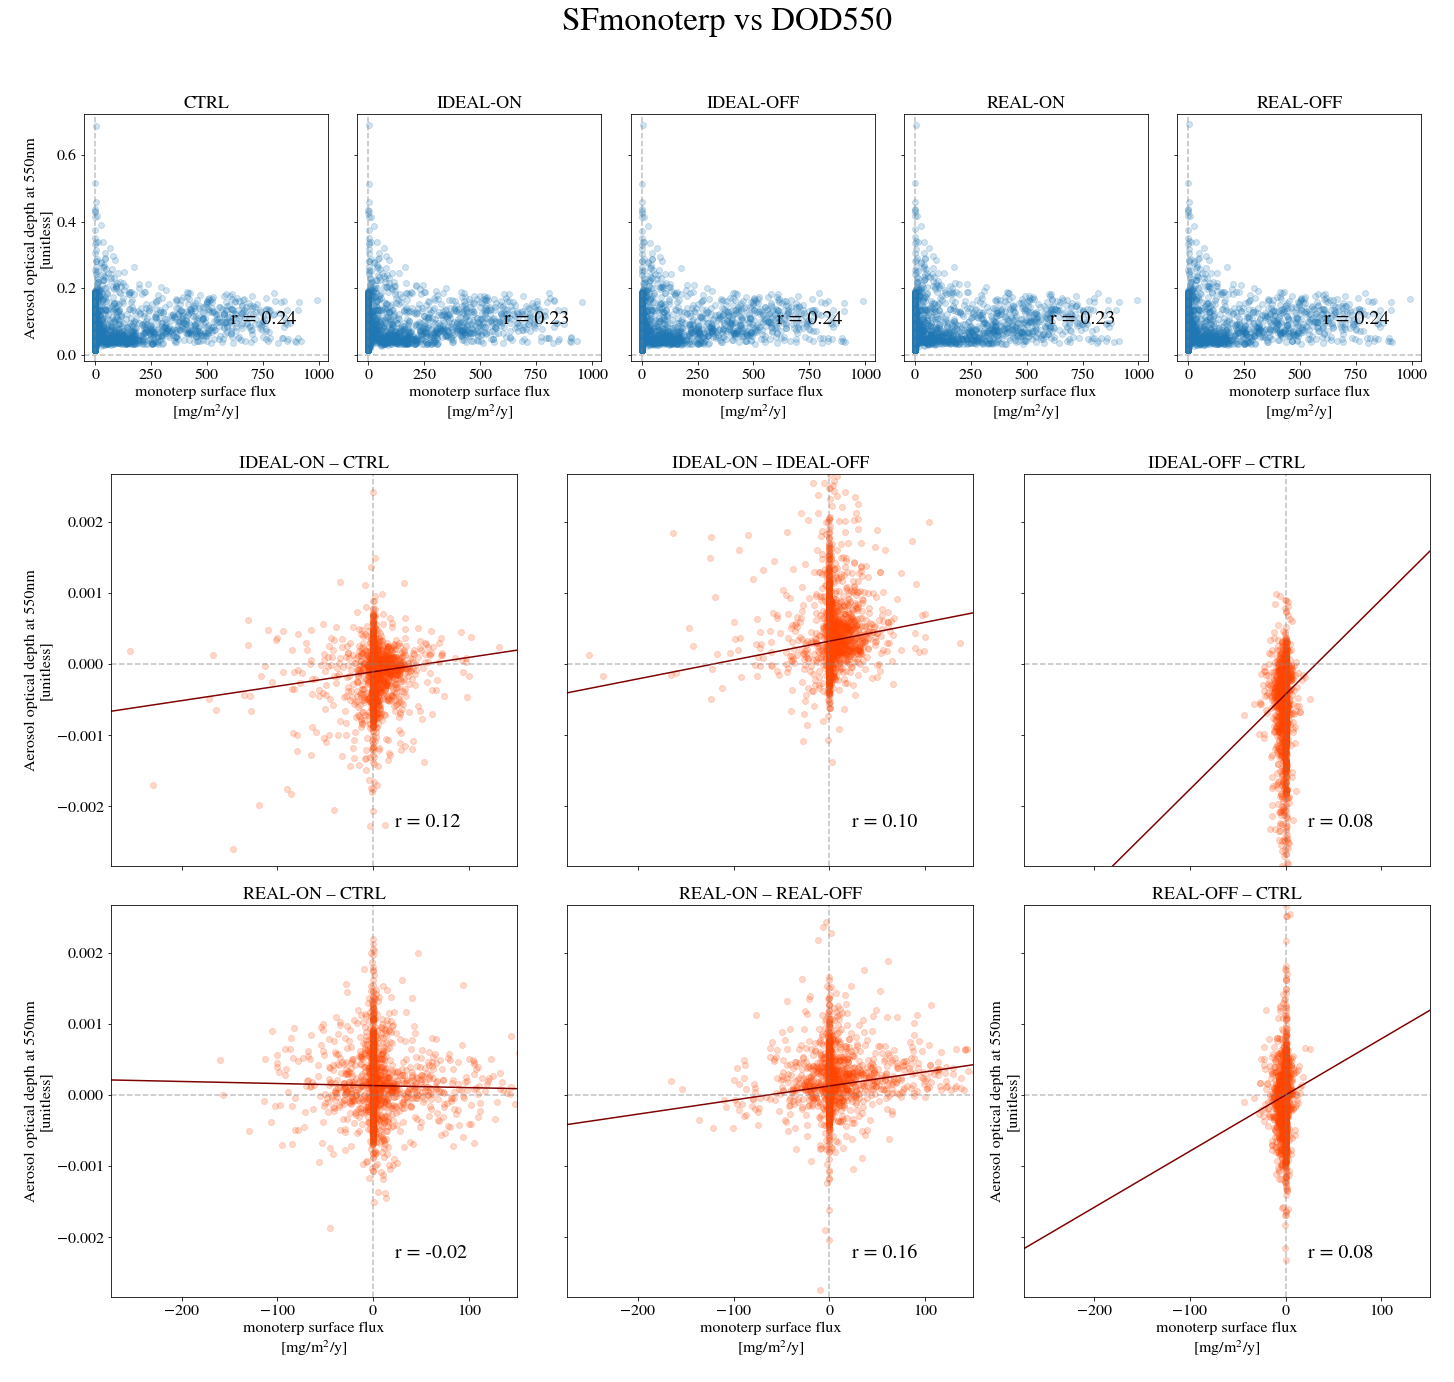

In [11]:
for var1 in ['SFisoprene', 'SFmonoterp']:
    for var2 in ['N_AER', 'cb_SOA_TOT', 'DOD550']:
        scatterplots(bvoc, soa, var1, var2, title = var1+' vs '+var2)